# **Demand Forecasting Optimization for Corporation Favorita A Time Series Regression ML Approach**


## **Business Understanding**

Corporation Favorita, a large grocery retailer based in Ecuador, aims to optimize its inventory management to ensure the right quantity of products is always in stock across its various locations. Effective inventory management is critical for maintaining high levels of customer satisfaction and minimizing costs associated with overstocking or stockouts.

To achieve this goal, we will build machine learning models to forecast the demand for products at different Favorita stores. Accurate demand forecasting will allow Corporation Favorita to make informed decisions regarding stock levels, promotions, and supply chain logistics.

#### Objective:
1. **Develop Predictive Models**: Create models to forecast daily unit sales for thousands of products across multiple stores.
2. **Understand Influencing Factors**: Analyze the impact of various factors on sales, including promotions, holidays, oil prices, store characteristics, and external events such as earthquakes.
3. **Optimize Inventory Management**: Use the models to inform inventory decisions, ensuring that the right products are available at the right stores at the right time.

#### Hypothesis:
1. Null Hypothesis (H0): Promotions do not have a significant impact on sales.  
   Alternative Hypothesis (H1): Promotions have a significant impact on sales.
2. Null Hypothesis (H0): Oil prices do not significantly impact sales.  
   Alternative Hypothesis (H1): Oil prices significantly impact sales.

#### Key Analytical Questions:
1. **Data Completeness**: Is the training dataset complete with all required dates?
2. **Sales Extremes**: Which dates have the lowest and highest sales for each year (excluding days when stores were closed)?
3. **Monthly Sales Trends**: Compare sales across months and years to identify the highest sales month and year.
4. **Earthquake Impact**: Did the earthquake in April 2016 impact sales?
5. **Store Performance**: Are certain stores or groups of stores (cluster, city, state, type) selling more products?
6. **Promotions, Oil Prices, and Holidays**: How are sales affected by promotions, oil prices, and holidays?
7. **Date Features Analysis**: What insights can be derived from date-related features?
8. **Promotion Impact**: Which product families and stores were most affected by promotions?
9. **Error Metrics**: What is the difference between RMSLE, RMSE, and MSE? Why might MAE be greater than these metrics?
10. **Wage Payment Influence**: Does the bi-monthly payment of public sector wages influence store sales?


#### Data Sources
- **train.csv**: Time series data of store, product information, promotions, and sales.
- **test.csv**: Features similar to the training data for the 15 days following the last date in the training data.
- **transaction.csv**: Daily transactions per store.
- **stores.csv**: Metadata about stores including location and type.
- **oil.csv**: Daily oil prices.
- **holidays_events.csv**: Information about holidays and events, including special designations like transferred, bridge, and work days.
- **sample_submission.csv**: A sample submission file for formatting predictions.

## **Importing Necessary packages**

In [1]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy import stats
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.ticker as ticker


# Library for feature scaling
from sklearn.preprocessing import MinMaxScaler

# Library for feature encoding
from sklearn.preprocessing import OneHotEncoder

# Libraries for modelling
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Libraries for calculating evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, make_scorer

# Library to make series stationary
from scipy.stats import boxcox

# Library for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Library for seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Library for checking stationarity
from statsmodels.tsa.stattools import adfuller

# Library for working with operating system
import os

# Library for saving the model components to a file
import pickle

# Library for creating zip file
import zipfile

import warnings
warnings.filterwarnings('ignore')


# Seaborn color palette
palette = sns.color_palette("tab10")

# Function to format y-axis labels in millions
def millions(x, pos):
    return '%1.0fM' % (x * 1e-6)

## **Data Collection**

In [2]:
# Loading environment variables from .env file
environment_variables = dotenv_values('.env')

# Getting the values for the credentials set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Creating a connection string
connection_string = f"DRIVER={{SQL Server}}; \
                    SERVER={server}; \
                    DATABASE={database}; \
                    UID={username}; \
                    PWD={password};"

# Connecting to the server
connection = pyodbc.connect(connection_string)

Loading data from the database

In [3]:
# Loading Oil dataset
oil = pd.read_sql_query("SELECT * FROM dbo.oil", connection)

# Saving the DataFrame to a CSV file
oil.to_csv('data/oil.csv', index=False)

oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [4]:
# Loading holidays_events dataset
holidays_events = pd.read_sql_query(
    "SELECT * FROM dbo.holidays_events", connection)

# Saving the DataFrame to a CSV file
holidays_events.to_csv('data/holidays_events.csv', index=False)

holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
# Loading stores dataset
stores = pd.read_sql_query("SELECT * FROM dbo.stores", connection)

# Saving the DataFrame to a CSV file
stores.to_csv('data/stores.csv', index=False)

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
train = pd.read_csv('Data/train.csv')

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [7]:
test = pd.read_csv('Data/test.csv')

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [8]:
transactions = pd.read_csv('Data/transactions.csv')

transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
sample_submission = pd.read_csv('Data/sample_submission.csv')

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


## **Data Cleaning and Preparation**

Handling Missing Values

In [10]:
# Checking for missing values in each dataset
missing_values_train = train.isnull().sum()
missing_values_test = test.isnull().sum()
missing_values_transactions = transactions.isnull().sum()
missing_values_stores = stores.isnull().sum()
missing_values_oil = oil.isnull().sum()
missing_values_holidays_events = holidays_events.isnull().sum()
missing_values_sample_submission = sample_submission.isnull().sum()

missing_values_train, missing_values_test, missing_values_transactions, missing_values_stores, missing_values_oil, missing_values_holidays_events, missing_values_sample_submission

(id             0
 date           0
 store_nbr      0
 family         0
 sales          0
 onpromotion    0
 dtype: int64,
 id             0
 date           0
 store_nbr      0
 family         0
 onpromotion    0
 dtype: int64,
 date            0
 store_nbr       0
 transactions    0
 dtype: int64,
 store_nbr    0
 city         0
 state        0
 type         0
 cluster      0
 dtype: int64,
 date           0
 dcoilwtico    43
 dtype: int64,
 date           0
 type           0
 locale         0
 locale_name    0
 description    0
 transferred    0
 dtype: int64,
 id       0
 sales    0
 dtype: int64)

In [11]:
# Filling missing values in the oil dataset using forward fill
oil['dcoilwtico'].fillna(method='ffill', inplace=True)

# Verifying that there are no more missing values
missing_values_oil = oil.isnull().sum()
missing_values_oil

date          0
dcoilwtico    1
dtype: int64

In [12]:
# Filling the remaining missing value using backward fill
oil['dcoilwtico'].fillna(method='bfill', inplace=True)

# Verifying that there are no more missing values
missing_values_oil = oil.isnull().sum()
missing_values_oil

date          0
dcoilwtico    0
dtype: int64

Correcting Data Types

In [13]:
# Converting date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

Merging Datasets

In [14]:
# Merging train dataset with transactions, stores, oil, and holidays_events
train_merged = train.merge(transactions, on=['date', 'store_nbr'], how='left')
train_merged = train_merged.merge(stores, on='store_nbr', how='left')
train_merged = train_merged.merge(oil, on='date', how='left')
train_merged = train_merged.merge(holidays_events, on='date', how='left')

# Repeating the same for the test dataset
test_merged = test.merge(transactions, on=['date', 'store_nbr'], how='left')
test_merged = test_merged.merge(stores, on='store_nbr', how='left')
test_merged = test_merged.merge(oil, on='date', how='left')
test_merged = test_merged.merge(holidays_events, on='date', how='left')

In [15]:
# renaming relevant columns 
train_merged.rename(columns={'type_x': 'store_type','type_y': 'holiday_type'}, inplace=True)
test_merged.rename(columns={'type_x': 'store_type','type_y': 'holiday_type'}, inplace=True)

In [16]:
# Filling null values in transactions with 0
train_merged['transactions'].fillna(0, inplace=True)
test_merged['transactions'].fillna(0, inplace=True)

# Forward filling and backward filling for dcoilwtico
train_merged['dcoilwtico'].fillna(method='ffill', inplace=True)
train_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

test_merged['dcoilwtico'].fillna(method='ffill', inplace=True)
test_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

# Filling holiday-related columns with 'None'
holiday_related_cols = ['holiday_type', 'locale','locale_name', 'description', 'transferred']
train_merged[holiday_related_cols] = train_merged[holiday_related_cols].fillna('None')
test_merged[holiday_related_cols] = test_merged[holiday_related_cols].fillna('None')

Creating Date Features

In [17]:
# Create additional features from the date
train_merged['year'] = train_merged['date'].dt.year
train_merged['month'] = train_merged['date'].dt.month
train_merged['day'] = train_merged['date'].dt.day
train_merged['dayofweek'] = train_merged['date'].dt.dayofweek

test_merged['year'] = test_merged['date'].dt.year
test_merged['month'] = test_merged['date'].dt.month
test_merged['day'] = test_merged['date'].dt.day
test_merged['dayofweek'] = test_merged['date'].dt.dayofweek

## **Exploratory Data Analysis (EDA)**

In [18]:
# # Grouping by date and sum sales to get the overall sales trend over time
sales_trend = train_merged.groupby('date')['sales'].sum().reset_index()

# # Grouping by year and month for monthly trend
sales_trend['year_month'] = sales_trend['date'].dt.to_period('M')
monthly_sales_trend = sales_trend.groupby(
     'year_month')['sales'].sum().reset_index()

# # Grouping by year for yearly trend
sales_trend['year'] = sales_trend['date'].dt.year
yearly_sales_trend = sales_trend.groupby('year')['sales'].sum().reset_index()

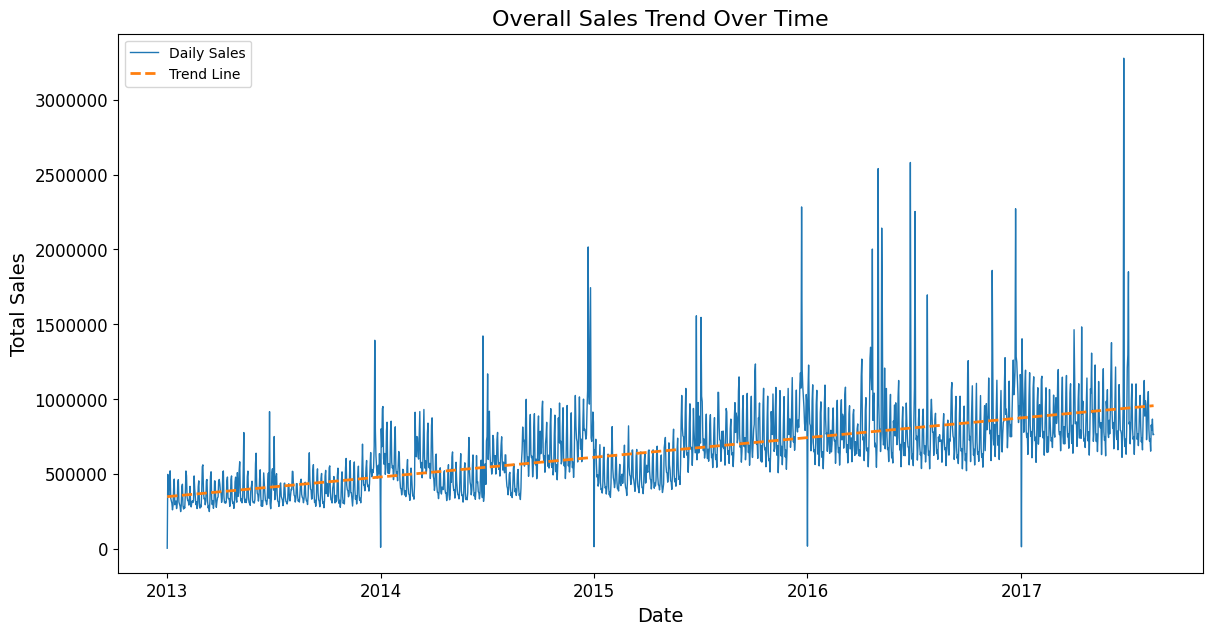

In [19]:
# # Plotting overall sales trend
plt.figure(figsize=(14, 7))
plt.plot(sales_trend['date'], sales_trend['sales'],
          color=palette[0], linewidth=1, label='Daily Sales')
plt.title('Overall Sales Trend Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

# # Formatting y-axis to avoid exponents
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# # Adding a trend line for better visualization
z = np.polyfit(sales_trend['date'].apply(lambda x: x.toordinal()), sales_trend['sales'], 1)
p = np.poly1d(z)
plt.plot(sales_trend['date'], p(sales_trend['date'].apply(lambda x: x.toordinal())), 
         color=palette[1], linestyle='--', linewidth=2, label='Trend Line')

plt.legend()
plt.show()

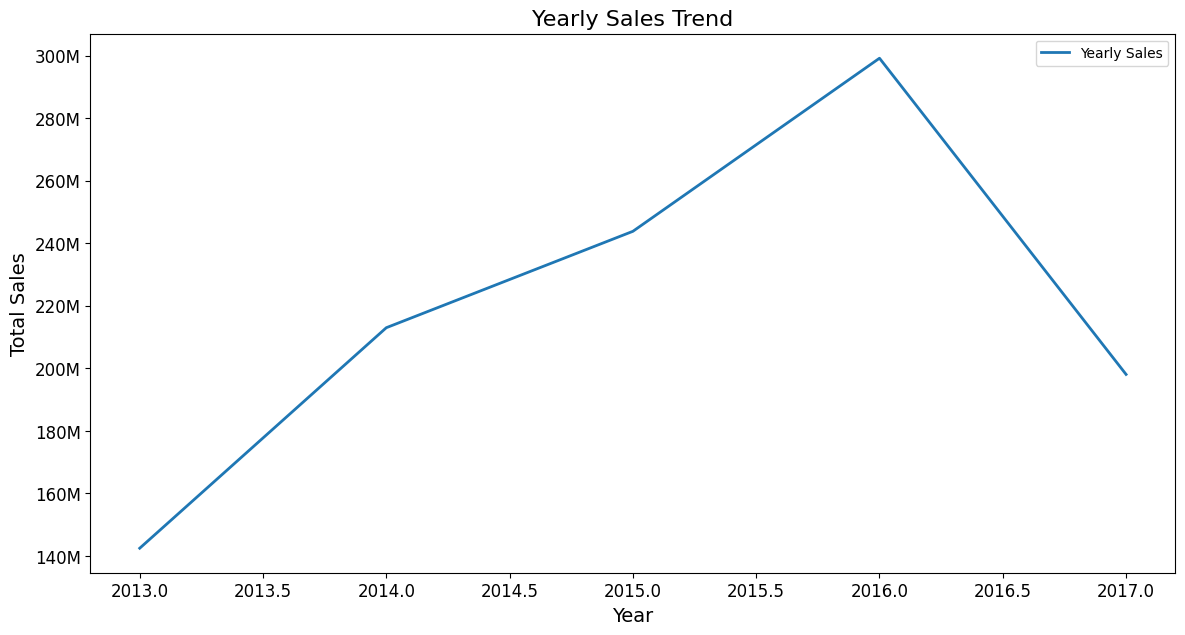

In [20]:
# # Plotting yearly sales trend
plt.figure(figsize=(14, 7))
plt.plot(yearly_sales_trend['year'], yearly_sales_trend['sales'],
         color=palette[0], linewidth=2, label='Yearly Sales')
plt.title('Yearly Sales Trend', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.legend()
plt.show()

### Sales Distribution Across Stores and Product Families

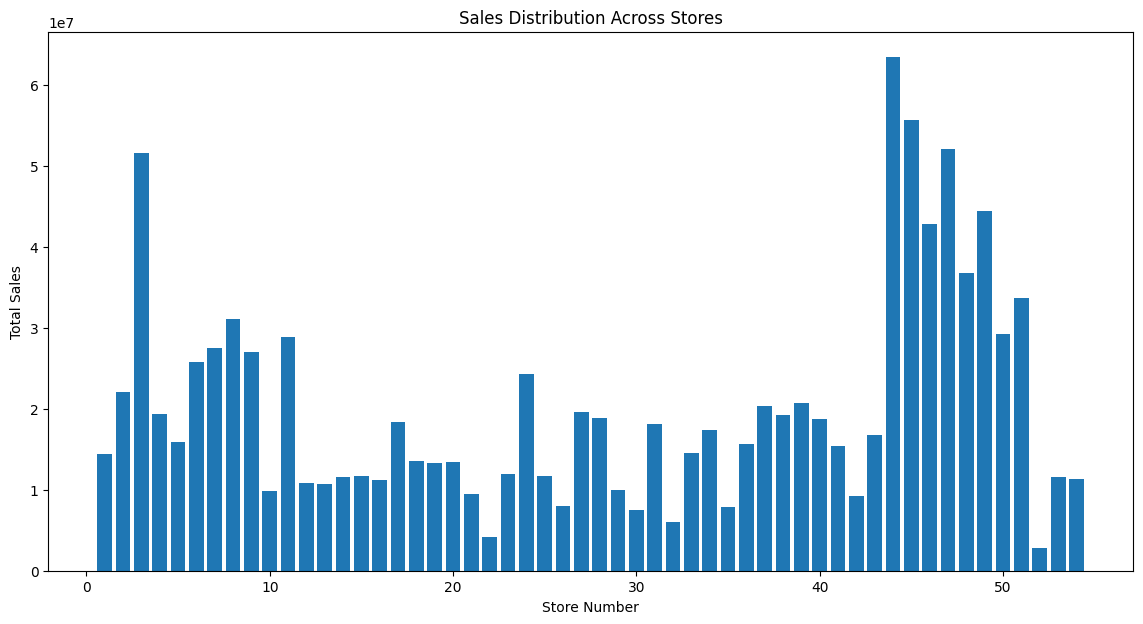

In [21]:
# # Aggregate sales by store and product family
store_sales = train_merged.groupby('store_nbr')['sales'].sum(
 ).sort_values(ascending=False).reset_index()
family_sales = train_merged.groupby(
    'family')['sales'].sum().sort_values(ascending=False).reset_index()

# # Plot sales distribution across stores
plt.figure(figsize=(14, 7))
plt.bar(store_sales['store_nbr'], store_sales['sales'])
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Sales Distribution Across Stores')
plt.show()

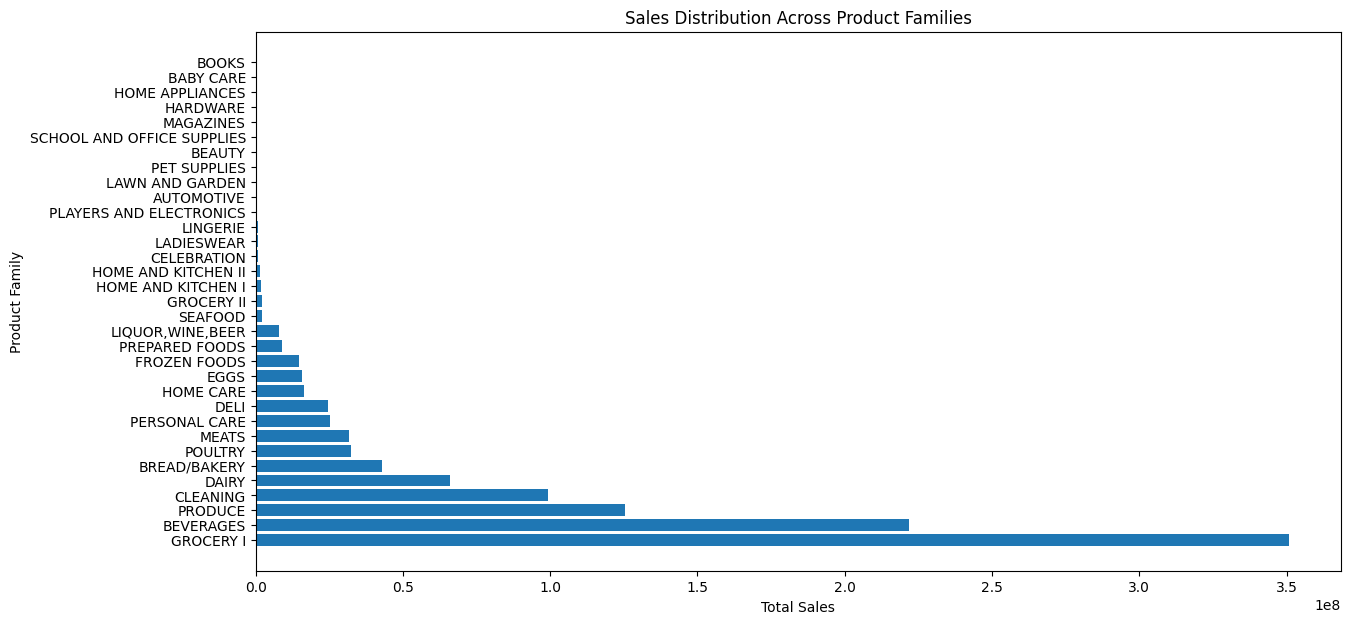

In [22]:
# # Plot sales distribution across product families
plt.figure(figsize=(14, 7))
plt.barh(family_sales['family'], family_sales['sales'])
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.title('Sales Distribution Across Product Families')
plt.show()

### Impact of Promotions

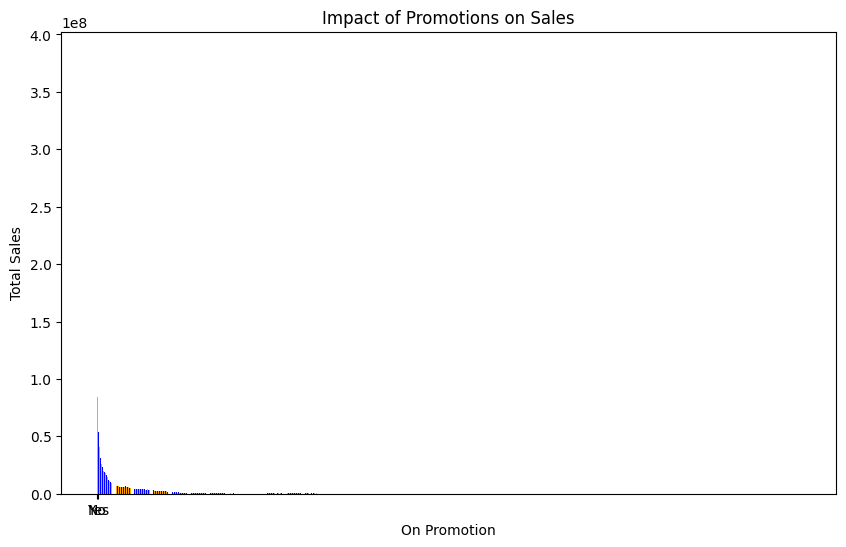

In [23]:
# # Aggregate sales by promotion status
promotion_sales = train_merged.groupby(
    'onpromotion')['sales'].sum().reset_index()

# # Plot impact of promotions on sales
plt.figure(figsize=(10, 6))
plt.bar(promotion_sales['onpromotion'],
       promotion_sales['sales'], color=['blue', 'orange'])
plt.xlabel('On Promotion')
plt.ylabel('Total Sales')
plt.title('Impact of Promotions on Sales')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

### Impact of Oil Prices

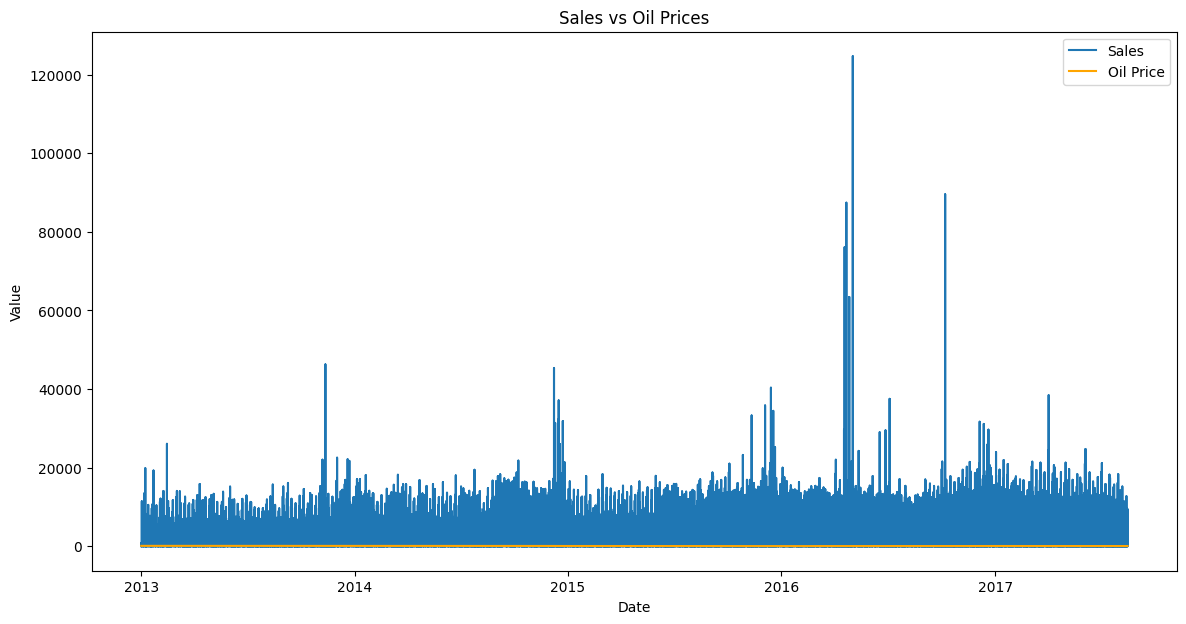

In [24]:
#  Plot sales versus oil prices
plt.figure(figsize=(14, 7))
plt.plot(train_merged['date'], train_merged['sales'], label='Sales')
plt.plot(train_merged['date'], train_merged['dcoilwtico'],
         label='Oil Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sales vs Oil Prices')
plt.legend()
plt.show()

### Impact of Holidays

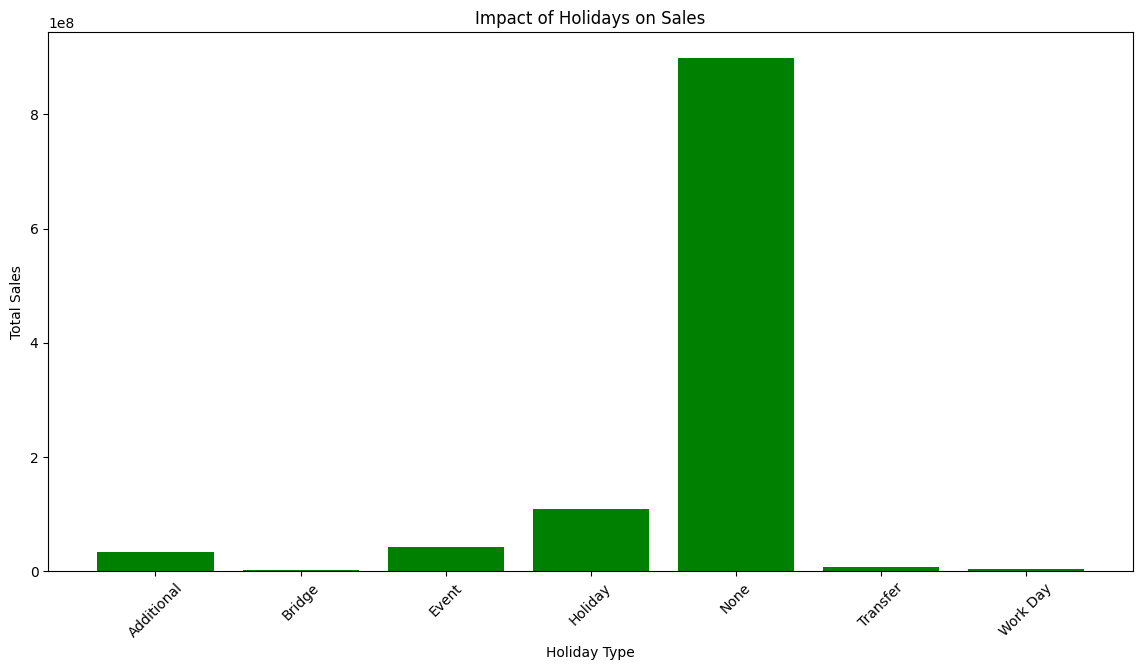

In [25]:
#  Aggregate sales by holiday status
holiday_sales = train_merged.groupby(
    'holiday_type')['sales'].sum().reset_index()

#  Plot impact of holidays on sales
plt.figure(figsize=(14, 7))
plt.bar(holiday_sales['holiday_type'], holiday_sales['sales'], color='green')
plt.xlabel('Holiday Type')
plt.ylabel('Total Sales')
plt.title('Impact of Holidays on Sales')
plt.xticks(rotation=45)
plt.show()

## **Hypothesis Testing**

Null Hypothesis (H0a): Promotions do not have a significant impact on sales.  

Alternative Hypothesis (H1a): Promotions have a significant impact on sales.

In [26]:
# Splitting the data into promotional and non-promotional periods
promotional_sales = train[train['onpromotion'] > 0]['sales']
non_promotional_sales = train[train['onpromotion'] == 0]['sales']

# Calculating descriptive statistics
promotional_mean = promotional_sales.mean()
non_promotional_mean = non_promotional_sales.mean()
promotional_std = promotional_sales.std()
non_promotional_std = non_promotional_sales.std()

print(f"Promotional Sales - Mean: {promotional_mean}, Std: {promotional_std}")
print(f"Non-Promotional Sales - Mean: {non_promotional_mean}, Std: {non_promotional_std}")

Promotional Sales - Mean: 1137.6937303133943, Std: 1928.5887066373123
Non-Promotional Sales - Mean: 158.2466813936427, Std: 614.8944509454778


In [27]:
# Performing t-test
t_stat, p_value = ttest_ind(promotional_sales, non_promotional_sales)

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpreting the results
alpha = 0.05
if p_value < alpha:
    print("We Reject the null hypothesis (H0a). Promotions have a significant impact on sales.")
else:
    print("Fail to reject the null hypothesis (H0a). Promotions do not have a significant impact on sales.")

T-Statistic: 664.1236909096903, P-Value: 0.0
We Reject the null hypothesis (H0a). Promotions have a significant impact on sales.


Null Hypothesis (H0b): Oil prices do not significantly impact sales.  

Alternative Hypothesis (H1b): Oil prices significantly impact sales.

In [28]:
# Removing rows with missing oil prices
oil_merged_data = train_merged.dropna(subset=['dcoilwtico'])

# Performing correlation analysis
correlation = oil_merged_data['sales'].corr(oil_merged_data['dcoilwtico'])
print(f"Correlation between sales and oil prices: {correlation}")

Correlation between sales and oil prices: -0.07542992345237809


In [29]:
# Performing linear regression analysis
X = oil_merged_data['dcoilwtico']
y = oil_merged_data['sales']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                 1.748e+04
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:42:13   Log-Likelihood:            -2.5735e+07
No. Observations:             3054348   AIC:                         5.147e+07
Df Residuals:                 3054346   BIC:                         5.147e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        579.8744      1.786    324.672      0.0

In [30]:
# Extract the p-value for the oil price coefficient
p_value = model.pvalues['dcoilwtico']
print(f"P-Value for oil prices: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0b). Oil prices significantly impact sales.")
else:
    print("Fail to reject the null hypothesis (H0b). Oil prices do not significantly impact sales.")

P-Value for oil prices: 0.0
Reject the null hypothesis (H0b). Oil prices significantly impact sales.


## **Analytical Questions**

### 1. Checking if the train dataset complete (has all the required dates)?

In [31]:
# Determining the start and end dates in the train dataset
start_date = train['date'].min()
end_date = train['date'].max()

# Creating a complete date range from start to end date
complete_date_range = pd.date_range(start=start_date, end=end_date)

# Extracting the unique dates from the train dataset
unique_dates_in_train = train['date'].unique()

# Finding any missing dates by comparing the complete date range to the dates in the train dataset
missing_dates = set(complete_date_range) - set(unique_dates_in_train)

print(f"Start Date in Train Dataset: {start_date}")
print(f"End Date in Train Dataset: {end_date}")
print(f"Number of Unique Dates in Train Dataset: {len(unique_dates_in_train)}")
print(f"Number of Dates in Complete Range: {len(complete_date_range)}")
print(f"Missing Dates: {sorted(missing_dates)}")

Start Date in Train Dataset: 2013-01-01 00:00:00
End Date in Train Dataset: 2017-08-15 00:00:00
Number of Unique Dates in Train Dataset: 1684
Number of Dates in Complete Range: 1688
Missing Dates: [Timestamp('2013-12-25 00:00:00'), Timestamp('2014-12-25 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2016-12-25 00:00:00')]


In [32]:
# creating variables as arguments for the product() method
uniques_stores = train_merged.store_nbr.unique()
unique_family = train_merged.family.unique()

In [33]:
# we will replace the missing dates by pairing it with all the unique stores and families
replace_dates = list(product(missing_dates, uniques_stores,unique_family ))

In [34]:
# creating a dataframe for the replaced dates
replace_dates_df = pd.DataFrame(replace_dates, columns=['date', 'store_nbr', 'family'])
replace_dates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7128 entries, 0 to 7127
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       7128 non-null   datetime64[ns]
 1   store_nbr  7128 non-null   int64         
 2   family     7128 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 167.2+ KB


In [35]:
# adding replaced dates to our train data
train_merged = pd.concat([train_merged, replace_dates_df], ignore_index=True)

missing_dates = pd.date_range(start='2013-01-01', end='2017-08-15').difference(train_merged.date)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

### 2. Determining which dates have the lowest and highest sales for each year(excluding days the store was closed)?

In [36]:
# Identifying dates when stores were closed (i.e., zero transactions)
closed_dates = transactions[transactions['transactions'] == 0]['date'].unique()

# Filtering out closed dates from the sales data
sales_data = train_merged[~train_merged['date'].isin(closed_dates)]

In [37]:
# Initializing dictionaries to store the results
lowest_sales_dates = {}
highest_sales_dates = {}

# Grouping by year and find the dates with the lowest and highest sales
for year, group in sales_data.groupby('year'):
    lowest_sales_row = group.loc[group['sales'].idxmin()]
    highest_sales_row = group.loc[group['sales'].idxmax()]
    lowest_sales_dates[year] = (lowest_sales_row['date'], lowest_sales_row['sales'])
    highest_sales_dates[year] = (highest_sales_row['date'], highest_sales_row['sales'])

# Creating DataFrames to display the results
lowest_sales_df = pd.DataFrame(list(lowest_sales_dates.items()), 
                               columns=['Year', 'Lowest Sales Data'])
highest_sales_df = pd.DataFrame(list(highest_sales_dates.items()), 
                                columns=['Year', 'Highest Sales Data'])

# Splitting the tuple into separate columns
lowest_sales_df[['Lowest Sales Date', 'Lowest Sales']] = pd.DataFrame(
    lowest_sales_df['Lowest Sales Data'].tolist(), index=lowest_sales_df.index)
highest_sales_df[['Highest Sales Date', 'Highest Sales']] = pd.DataFrame(
    highest_sales_df['Highest Sales Data'].tolist(), index=highest_sales_df.index)

# Dropping the original tuple columns
lowest_sales_df.drop(columns=['Lowest Sales Data'], inplace=True)
highest_sales_df.drop(columns=['Highest Sales Data'], inplace=True)

print("Dates with the Lowest Sales for Each Year:")
print(lowest_sales_df)
print("\nDates with the Highest Sales for Each Year:")
print(highest_sales_df)

Dates with the Lowest Sales for Each Year:
     Year Lowest Sales Date  Lowest Sales
0  2013.0        2013-01-01           0.0
1  2014.0        2014-01-01           0.0
2  2015.0        2015-01-01           0.0
3  2016.0        2016-01-01           0.0
4  2017.0        2017-01-01           0.0

Dates with the Highest Sales for Each Year:
     Year Highest Sales Date  Highest Sales
0  2013.0         2013-11-12      46271.000
1  2014.0         2014-12-08      45361.000
2  2015.0         2015-12-14      40351.460
3  2016.0         2016-05-02     124717.000
4  2017.0         2017-04-02      38422.625


### 3. Comparing the sales for each month across the years and determine which month of which year had the highest sales.

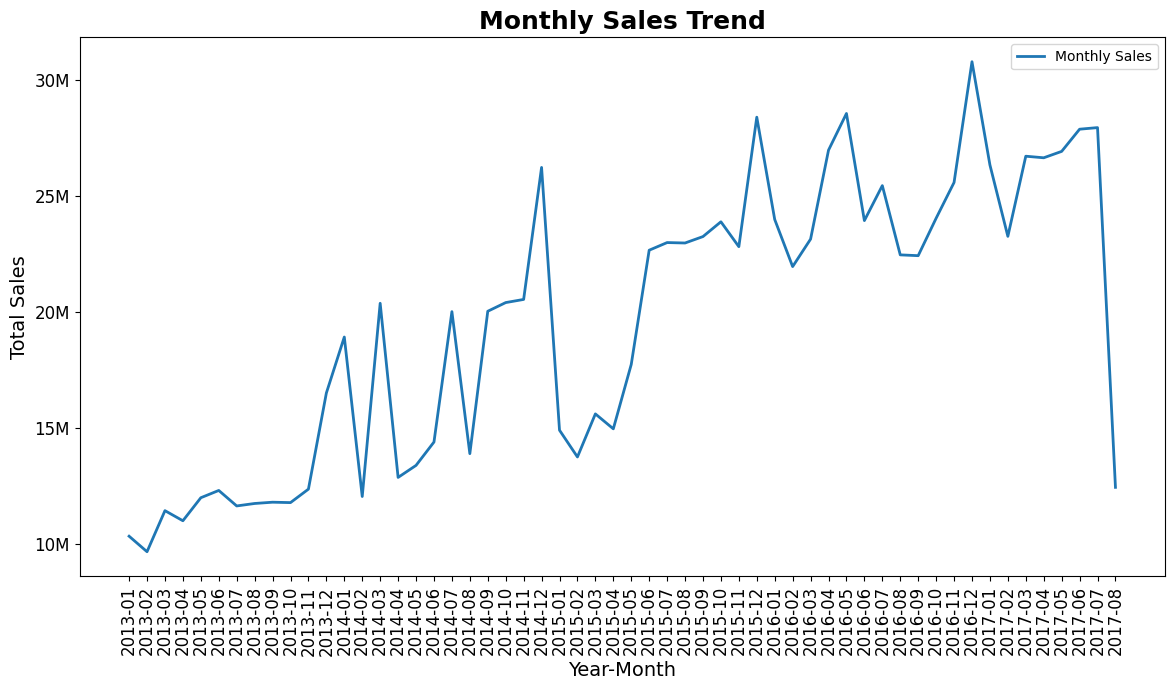

In [38]:
# Grouping by date and sum sales to get the overall sales trend over time
sales_trend = train_merged.groupby('date')['sales'].sum().reset_index()

# Grouping by year and month for monthly trend
sales_trend['year_month'] = sales_trend['date'].dt.to_period('M')
monthly_sales_trend = sales_trend.groupby('year_month')['sales'].sum().reset_index()


# Plotting monthly sales trend
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales_trend['year_month'].astype(str),
         monthly_sales_trend['sales'], color=palette[0], linewidth=2, label='Monthly Sales')
plt.title('Monthly Sales Trend', fontsize=18, weight='bold')
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=90)

# Formatting y-axis exponents
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.legend()
plt.show()

1. **General Trend**:
   - The overall trend indicates a steady increase in monthly sales from 2013 to 2017.
   - There are noticeable peaks and troughs, indicating seasonal variations and possibly promotional events or holidays affecting sales.

2. **Highest Sales Month**:
   - The highest sales month across all years is `May 2016`, with sales reaching approximately `30 million`. This peak is significantly higher than other months, suggesting a major event or promotion during that period.

3. **Seasonal Patterns**:
   - Sales tend to peak towards the end of the year, particularly in November and December, likely due to holiday shopping.
   - Another notable peak occurs around mid-year (June and July), which may correspond to mid-year sales events or summer holidays.

4. **Year-over-Year Comparison**:
   - Each year shows an increasing trend in sales for most months, indicating growth in business and possibly an expanding customer base.
   - The months of November and December consistently show higher sales across the years, reinforcing the impact of holiday shopping on sales performance.

5. **Significant Peaks**:
   - The graph shows significant peaks not only in May 2016 but also in December 2014, and November 2013, indicating these months had exceptionally high sales compared to their respective years.


### 4. Did the earthquake impact sales?

NB:A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

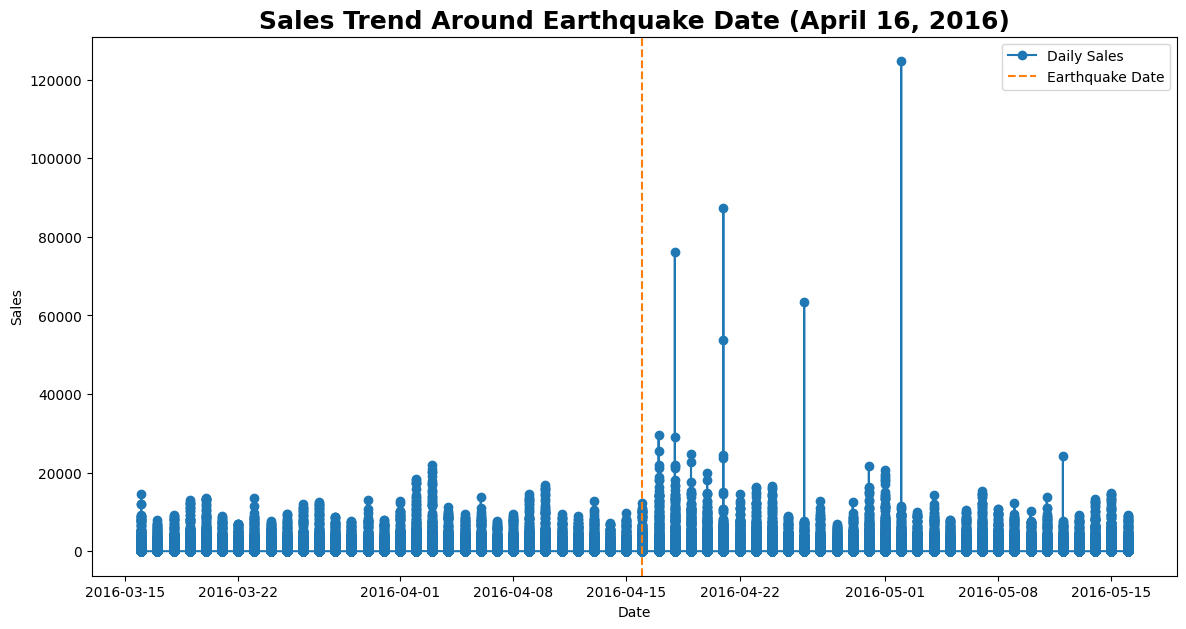

In [39]:
# Defining the period around the earthquake date (1 month before and 1 month after)
start_date = '2016-03-16'
end_date = '2016-05-16'
earthquake_date = '2016-04-16'

# Filtering data for the defined period
filtered_data = train[(train['date'] >= start_date) & (train['date'] <= end_date)]

plt.figure(figsize=(14, 7))
plt.plot(filtered_data['date'], filtered_data['sales'], marker='o', linestyle='-', color=palette[0], label='Daily Sales')
plt.axvline(pd.to_datetime(earthquake_date), color=palette[1], linestyle='--', label='Earthquake Date')
plt.title('Sales Trend Around Earthquake Date (April 16, 2016)',
          fontsize=18, weight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

1. **Immediate Sales Increase Post-Earthquake**:
   - There is a noticeable spike in sales immediately after the earthquake on April 16, 2016. This spike is evident within the first few days following the earthquake and is significantly higher compared to the sales before the earthquake.

2. **Sustained High Sales**:
   - Sales remain elevated for several weeks following the earthquake. This indicates that the earthquake had a prolonged impact on sales, likely due to ongoing relief efforts and increased demand for essential goods.

3. **Peak Sales**:
   - The highest sales point within the observed period occurs shortly after the earthquake, suggesting a direct correlation between the event and the surge in sales.

4. **Pre-Earthquake Sales Stability**:
   - Sales prior to the earthquake show a relatively stable pattern with minor fluctuations, indicating a normal sales period before the disruptive event.

In [40]:
# Defining periods before and after the earthquake
before_earthquake = filtered_data[filtered_data['date'] < earthquake_date]
after_earthquake = filtered_data[filtered_data['date'] >= earthquake_date]

# Performing t-test
t_stat, p_value = ttest_ind(
    before_earthquake['sales'], after_earthquake['sales'])

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("We Reject the null hypothesis. The earthquake had a significant impact on sales.")
else:
    print("We Fail to reject the null hypothesis. The earthquake did not have a significant impact on sales.")

T-Statistic: -8.452960671870839, P-Value: 2.873983188994139e-17
We Reject the null hypothesis. The earthquake had a significant impact on sales.


### 5. Are certain groups of stores selling more products? (Cluster, city, state, type)

Sales by Cluster

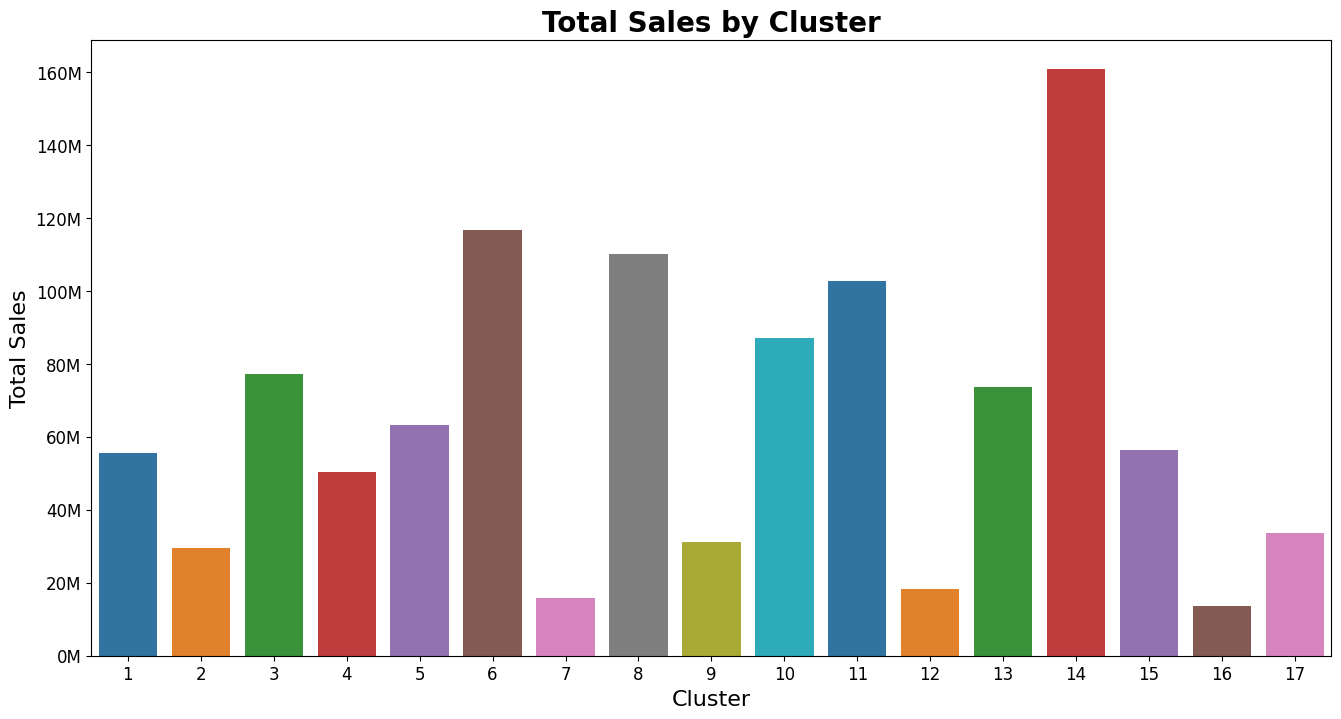

In [41]:
# Grouping by cluster and calculate total sales
cluster_sales = train_merged.groupby('cluster')['sales'].sum().reset_index()
cluster_sales = cluster_sales.sort_values(by='cluster', ascending= True)

# Plotting total sales by cluster
plt.figure(figsize=(16, 8))
sns.barplot(x='cluster', y='sales', data=cluster_sales, palette=palette)
plt.title('Total Sales by Cluster', fontsize=20, weight='bold')
plt.xlabel('Cluster', fontsize=16)
plt.ylabel('Total Sales', fontsize=16)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(millions))
plt.xticks(ticks=range(len(cluster_sales)),
           labels=cluster_sales['cluster'].astype(int), fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- **Cluster with Highest Sales**:
  - Cluster `14` stands out with the highest total sales, significantly outperforming other clusters with over `160M` in sales. This indicates a particularly strong performance, possibly due to a higher number of stores, larger store sizes, or a more affluent customer base.

- **Other High-Performing Clusters**:
  - Clusters `6` and `8` also show high sales, with each generating over `120M` in sales. These clusters, along with cluster 14, make up the top three clusters in terms of sales performance.
  - Clusters `3`, `11`, and `13` follow closely behind, each with sales ranging between `80M` and `100M`. These clusters represent the mid-high range of sales performance.

- **Lower-Performing Clusters**:
  - Clusters `2`, `7`, `9`, `12`, and `16` have the lowest total sales, each generating less than `40M`. These clusters might consist of fewer stores, smaller store sizes, or be located in regions with lower customer demand.

Sales by City

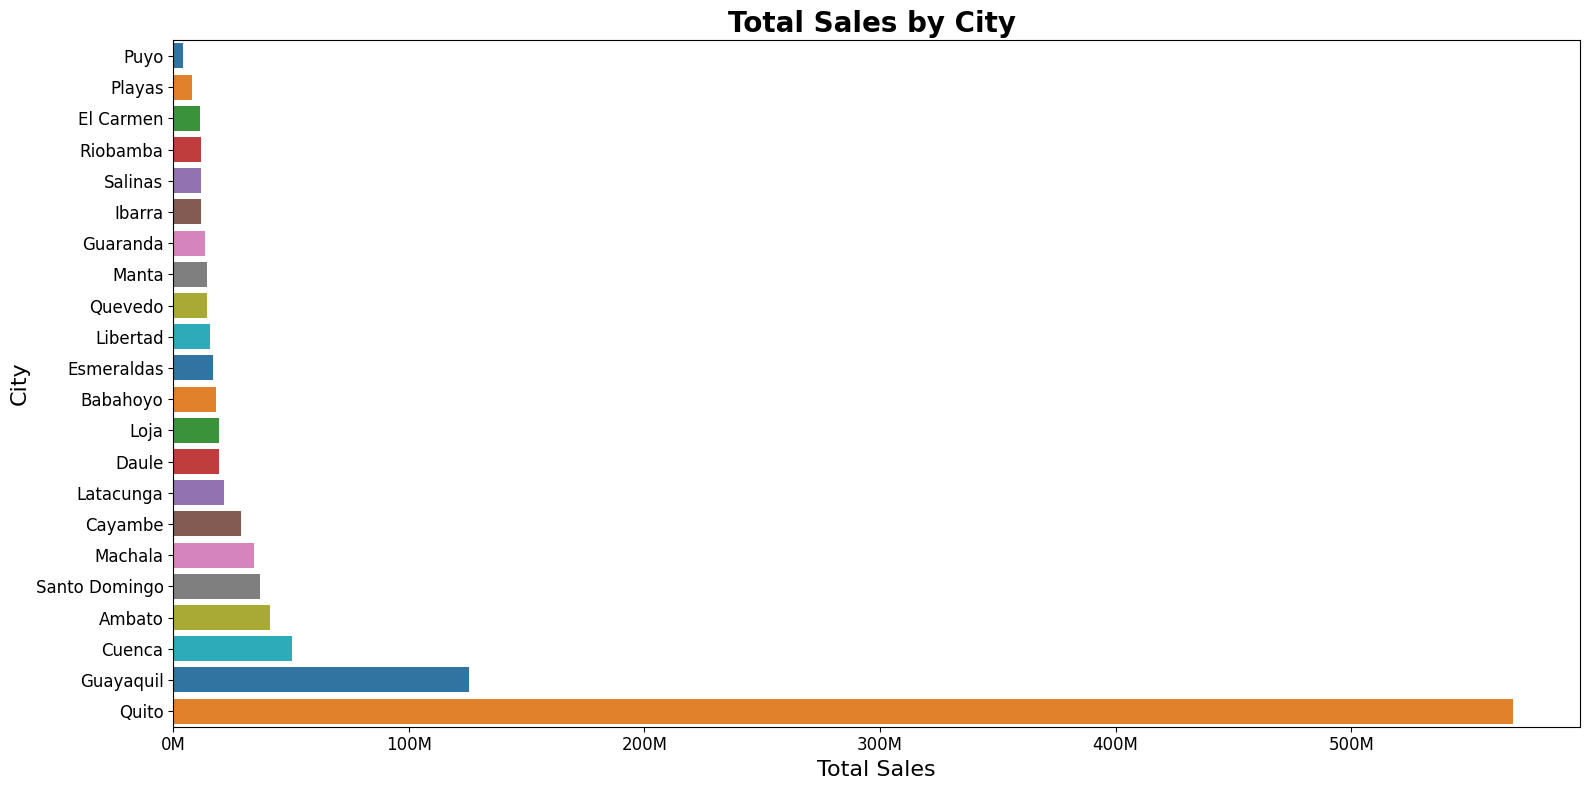

In [42]:
# Grouping by city and calculate total sales
city_sales = train_merged.groupby('city')['sales'].sum().reset_index()
city_sales = city_sales.sort_values(by='sales', ascending=True)

# Plotting total sales by city
plt.figure(figsize=(16, 8))
sns.barplot(x='sales', y='city', data=city_sales, palette=palette, orient='h')
plt.title('Total Sales by City ', fontsize=20, weight='bold')
plt.xlabel('Total Sales', fontsize=16)
plt.ylabel('City', fontsize=16)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(millions))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

- **City with Highest Sales**:
  - `Guayaquil` stands out with the highest total sales, significantly outperforming other cities with over `120M` in sales. This indicates that Guayaquil is a major commercial hub with high customer demand and purchasing power.

- **Other High-Performing Cities**:
  - `Cuenca` follows with around `80M` in sales, showing strong performance as well. It is a key city with substantial sales figures.
  - `Ambato` is next with over `40M` in sales, indicating a solid market presence.
  - Other notable cities include `Cayambe` and `Daule`, each contributing significantly to the total sales but with lower figures compared to the top three cities.

- **Lower-Performing Cities**:
  - Cities like `Babahoyo`, `El Carmen`, and `Guaranda` show relatively lower total sales, each generating less than `20M`. These cities might have fewer stores, smaller store sizes, or be located in regions with lower customer demand.

Sales by state

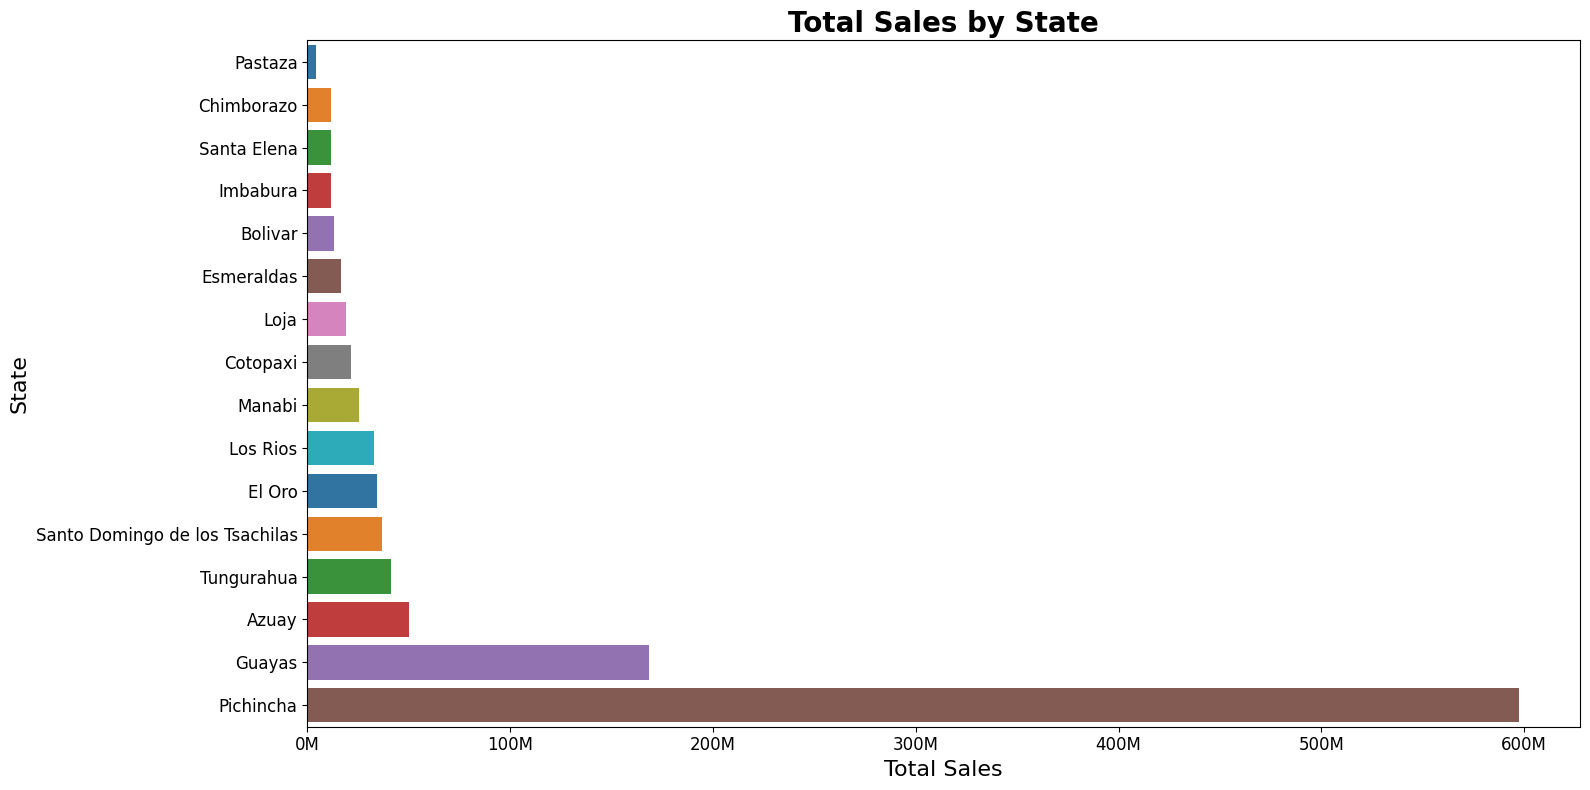

In [43]:
# Grouping by state and calculate total sales
state_sales = train_merged.groupby('state')['sales'].sum().reset_index()
state_sales = state_sales.sort_values(by='sales', ascending=True)

# Plotting total sales by state
plt.figure(figsize=(16, 8))
sns.barplot(x='sales', y='state', data=state_sales,
            palette=palette, orient='h')
plt.title('Total Sales by State', fontsize=20, weight='bold')
plt.xlabel('Total Sales', fontsize=16)
plt.ylabel('State', fontsize=16)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(millions))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

- **State with Highest Sales**:
  - `Pichincha` dominates with the highest total sales, significantly outperforming other states with `600M` in sales. This indicates that Pichincha, likely due to the presence of the capital city `Quito`, is a major commercial hub with high customer demand.

- **Other High-Performing States**:
  - `Guayas` follows with just below `200M` in sales, showing strong performance as well. It is a key state with substantial sales figures.
  - `Azuay`, `Santo Domingo de los Tsáchilas`, and other states each contribute significantly to the total sales but with lower figures compared to the top two states.

- **Lower-Performing States**:
  - States like `Pastaza`, `Chimborazo`, and `Santa Elena` show relatively lower total sales, each generating less than 10M. These states might have fewer stores, smaller store sizes, or be located in regions with lower customer demand.


Sales by Store Type

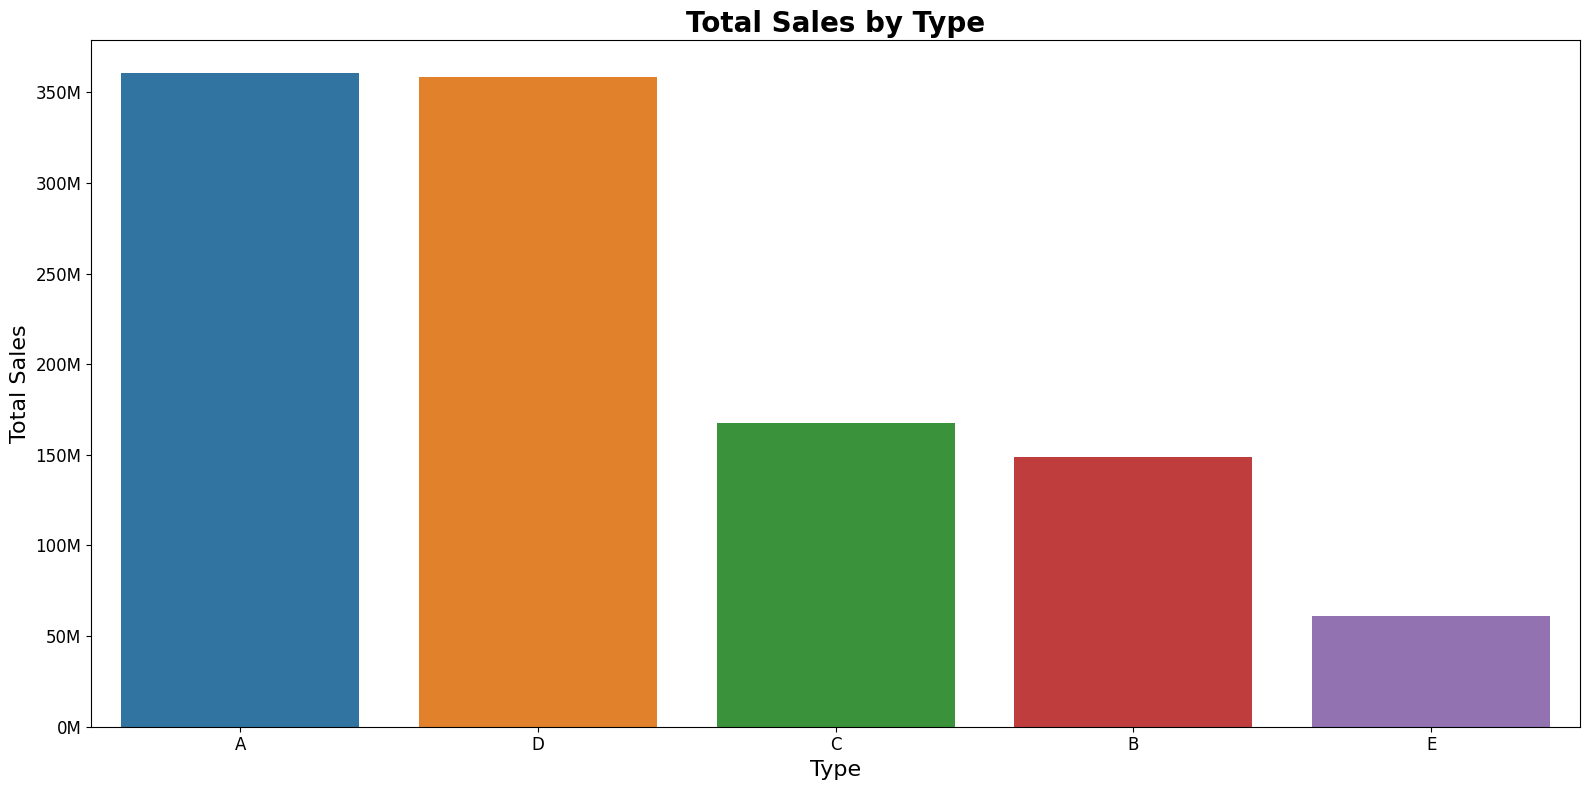

In [44]:
# Grouping by type and calculate total sales
type_sales = train_merged.groupby('store_type')['sales'].sum().reset_index()
type_sales = type_sales.sort_values(by='sales', ascending=False)

# Plotting total sales by type
plt.figure(figsize=(16, 8))
sns.barplot(x='store_type', y='sales', data=type_sales.sort_values(
    by='sales', ascending=False), palette=palette)
plt.title('Total Sales by Type', fontsize=20, weight='bold')
plt.xlabel('Type', fontsize=16)
plt.ylabel('Total Sales', fontsize=16)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(millions))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

- **Type with Highest Sales**:
  - Store types `A` and `D` dominate with the highest total sales, each generating over `350M`. This indicates that these store types are the most popular or have the highest number of stores.

- **Other High-Performing Types**:
  - Store types `C` and `B` follow with substantial sales, over `150M` each. These types also contribute significantly to the overall sales.

- **Lower-Performing Types**:
  - Store type `E` shows the lowest total sales, significantly less than the other types, with sales just over `50M`. This type might represent fewer stores or stores with lower customer demand.

### 6. Are sales affected by promotions, oil prices and holidays?

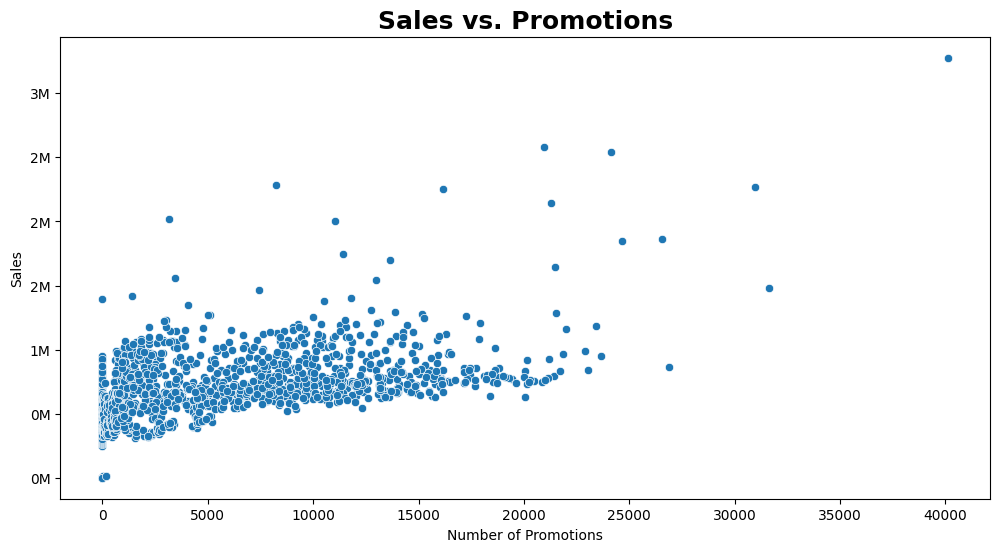

In [45]:
# Grouping the train data by date and sum the sales and onpromotion columns
promotions_sales_df = train_merged.groupby('date').agg(
    {'sales': 'sum', 'onpromotion': 'sum'}).reset_index()

# Plotting sales vs. promotions
plt.figure(figsize=(12, 6))
sns.scatterplot(x='onpromotion', y='sales', data=promotions_sales_df, palette=palette)
plt.title('Sales vs. Promotions', fontsize=18, weight='bold')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

plt.show()

In [46]:
# Calculating the correlation between sales and onpromotion
promotions_correlation = promotions_sales_df['sales'].corr(promotions_sales_df['onpromotion'])
promotions_correlation

0.5959208433846678

1. **Positive Correlation:**
   - The correlation coefficient is approximately `0.60`, indicating a moderate positive relationship between the number of promotions and sales. As the number of promotions increases, sales generally tend to increase.

2. **Outliers:**
   - There are notable outliers, particularly `one` data point where the number of promotions reaches around `40,000` and sales exceed `3` million. These outliers can significantly influence the overall analysis and warrant further investigation.

3. **Diminishing Returns:**
   - Beyond approximately `10,000` promotions, the increase in sales does not proportionally match the increase in promotions. This indicates diminishing returns on promotions, where additional promotions yield smaller increases in sales.

4. **Cluster of Data Points:**
   - A significant cluster of data points is observed between `0` to `10,000` promotions, with sales ranging mostly between `0` to `1` million. This indicates that most promotional activities fall within this range and still generate substantial sales.

5. **Non-linear Relationship:**
   - While the overall trend shows a positive correlation, the relationship between promotions and sales is not strictly linear. For example, increasing promotions from `20,000` to `30,000` does not lead to a proportionate increase in sales, suggesting other factors may also be influencing sales performance.

6. **Marketing Strategy Implications:**
   - The analysis suggests that businesses should evaluate the optimal number of promotions needed to maximize sales. Excessive promotional activities, particularly beyond `10,000` promotions, appear to yield diminishing returns and may not be cost-effective.


#### Impact of Oil Prices on Sales

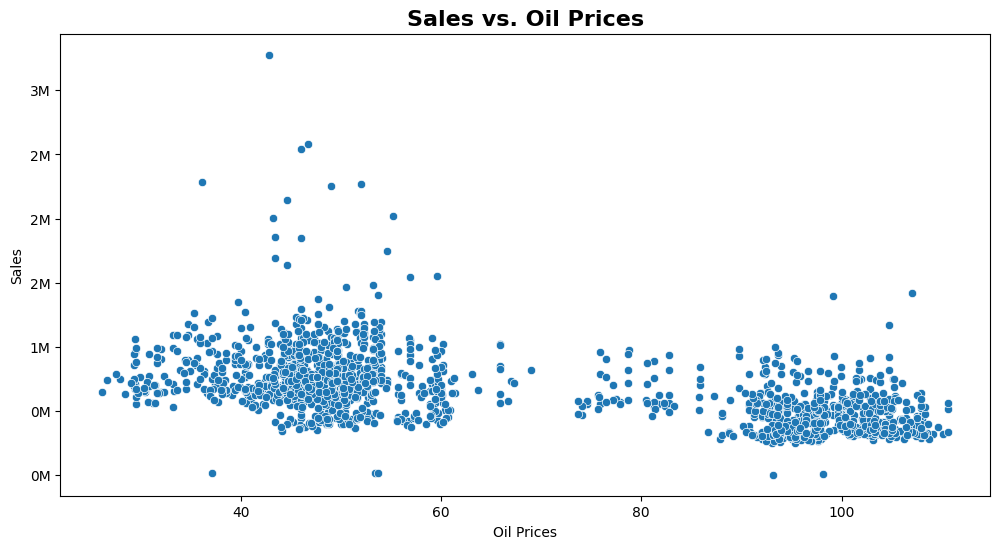

In [47]:
# Grouping the merged data by date and sum the sales
sales_oil_df_grouped = train_merged.groupby('date').agg({'sales': 'sum', 'dcoilwtico': 'mean'}).reset_index()

# Plotting sales vs. oil prices
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=sales_oil_df_grouped, palette=palette)
plt.title('Sales vs. Oil Prices', fontsize=16, weight='bold')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

plt.show()

In [48]:
# Calculating the correlation between sales and oil prices
oil_correlation = sales_oil_df_grouped['sales'].corr(sales_oil_df_grouped['dcoilwtico'])
oil_correlation

-0.5539891429786324

1. **Negative Correlation:**
   - The correlation coefficient is approximately `-0.55`, indicating a moderate negative relationship between oil prices and sales. This suggests that as oil prices increase, sales tend to decrease.

2. **Clusters of Data Points:**
   - Three main clusters of data points are visible:
     - **Oil Prices between `40` and `60`:** This cluster shows a wide range of sales values, mostly between `0` and `2` million.
     - **Oil Prices around `80`:** This cluster has fewer data points, with sales generally below `1` million.
     - **Oil Prices between `100` and `110`:** This cluster also shows a range of sales values, mostly between `0` and `1` million.

3. **Outliers:**
   - There are a few outliers where sales exceed `3` million, regardless of oil prices. These points can significantly influence the overall analysis and may require further investigation to understand the context behind such high sales.

4. **Distribution of Sales:**
   - The majority of sales data points are below `1` million, regardless of oil price levels. However, there is a notable density of sales below `2` million when oil prices are between `40` and `60`.

5. **Potential Influences:**
   - The moderate negative correlation suggests that higher oil prices may have an adverse effect on sales, possibly due to increased costs for consumers and businesses, reducing their purchasing power or expenditure on other goods.


#### Impact of Holidays on Sales

In [49]:
# Basic summary statistics of sales on holidays vs. non-holidays
sales_summary = train_merged.groupby('holiday_type')['sales'].describe()

sales_summary

,count,mean,std,min,25%,50%,75%,max
holiday_type,,,,,,,,
Additional,67716.0,487.628925,1414.266388,0.0,0.0,18.0,292.0000,31851.158
Bridge,5346.0,446.750854,1309.716490,0.0,0.0,16.0,273.9350,21367.000
Event,99792.0,425.660065,1401.016019,0.0,1.0,16.0,236.0000,124717.000
Holiday,304722.0,358.433812,1153.161110,0.0,0.0,10.0,189.0000,89576.360
None,2551824.0,352.159181,1076.081977,0.0,0.0,11.0,193.0000,40351.460
Transfer,16038.0,467.753110,1373.064925,0.0,2.0,24.0,264.0045,23966.000
Work Day,8910.0,372.157524,1167.569933,0.0,0.0,8.0,203.0000,18222.000


1. **Additional Holidays**:
   - Highest average sales among all holiday types with an average of `487.63`.
   - Standard deviation is high at `1414.27`, indicating a wide range of sales values.
   - Median sales (50th percentile) is `18`, suggesting that a majority of sales values are clustered at the lower end despite the high mean.

2. **Bridge Holidays**:
   - Second highest average sales at `446.75`.
   - Standard deviation of `1309.72`, showing a significant spread in the data.
   - Median sales are `16`, similar to Additional Holidays, showing a lower concentration of sales.

3. **Events**:
   - Average sales are `425.66`, slightly lower than Bridge Holidays.
   - High standard deviation of `1401.02`.
   - Median sales of `16`, indicating a concentration of sales towards the lower end.

4. **Holidays**:
   - Average sales drop to `358.43`.
   - Standard deviation is lower at `1153.16` compared to Additional, Bridge, and Event holidays.
   - Median sales are `10`, showing a significant portion of sales are lower.

5. **Non-Holidays (None)**:
   - Average sales are `352.16`, the lowest among all categories except for Work Day.
   - Standard deviation of `1076.08`.
   - Median sales are `11`, indicating a higher concentration of lower sales values.

6. **Transfer Holidays**:
   - Average sales are relatively high at `467.75`.
   - Standard deviation is `1373.06`.
   - Median sales are `24`, higher than the median sales of other holiday types, indicating relatively higher sales even at the lower end.

7. **Work Days**:
   - Average sales are `372.16`.
   - Standard deviation of `1167.57`.
   - Median sales are `8`, showing a lower concentration of sales compared to other holiday types.

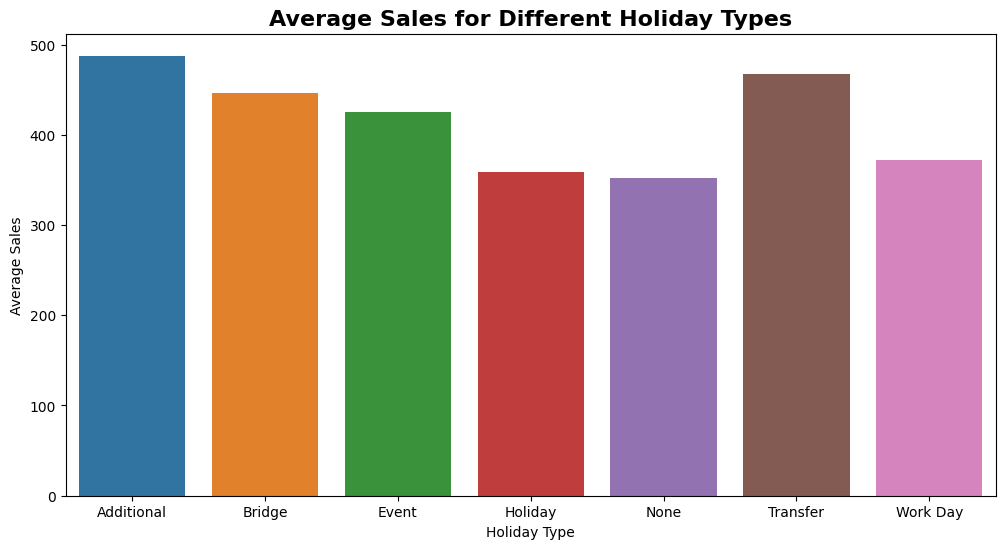

In [50]:
# Grouping by holiday type to get the total sales for each type
sales_by_holiday_type = train_merged.groupby('holiday_type')['sales'].mean().reset_index()

# Plotting average sales for different holiday types
plt.figure(figsize=(12, 6))
sns.barplot(x='holiday_type', y='sales',data=sales_by_holiday_type, palette=palette)
plt.title('Average Sales for Different Holiday Types',fontsize=16, weight='bold')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.show()

- **Additional** and **Transfer** holidays result in the highest average sales, suggesting these holidays might drive significant consumer activity.
- **Bridge**, **Event**, and **Work Day** holidays also show relatively high average sales, indicating their potential importance for sales strategies.
- **Non-Holidays** (None) have the lowest average sales, which could imply that regular days without any special events or holidays are less likely to drive high sales.
- The high standard deviations across all categories indicate a wide variability in sales, highlighting the need for targeted marketing strategies to maximize sales on different holiday types.

### 7. What analysis can we get from the date and its extractable features?

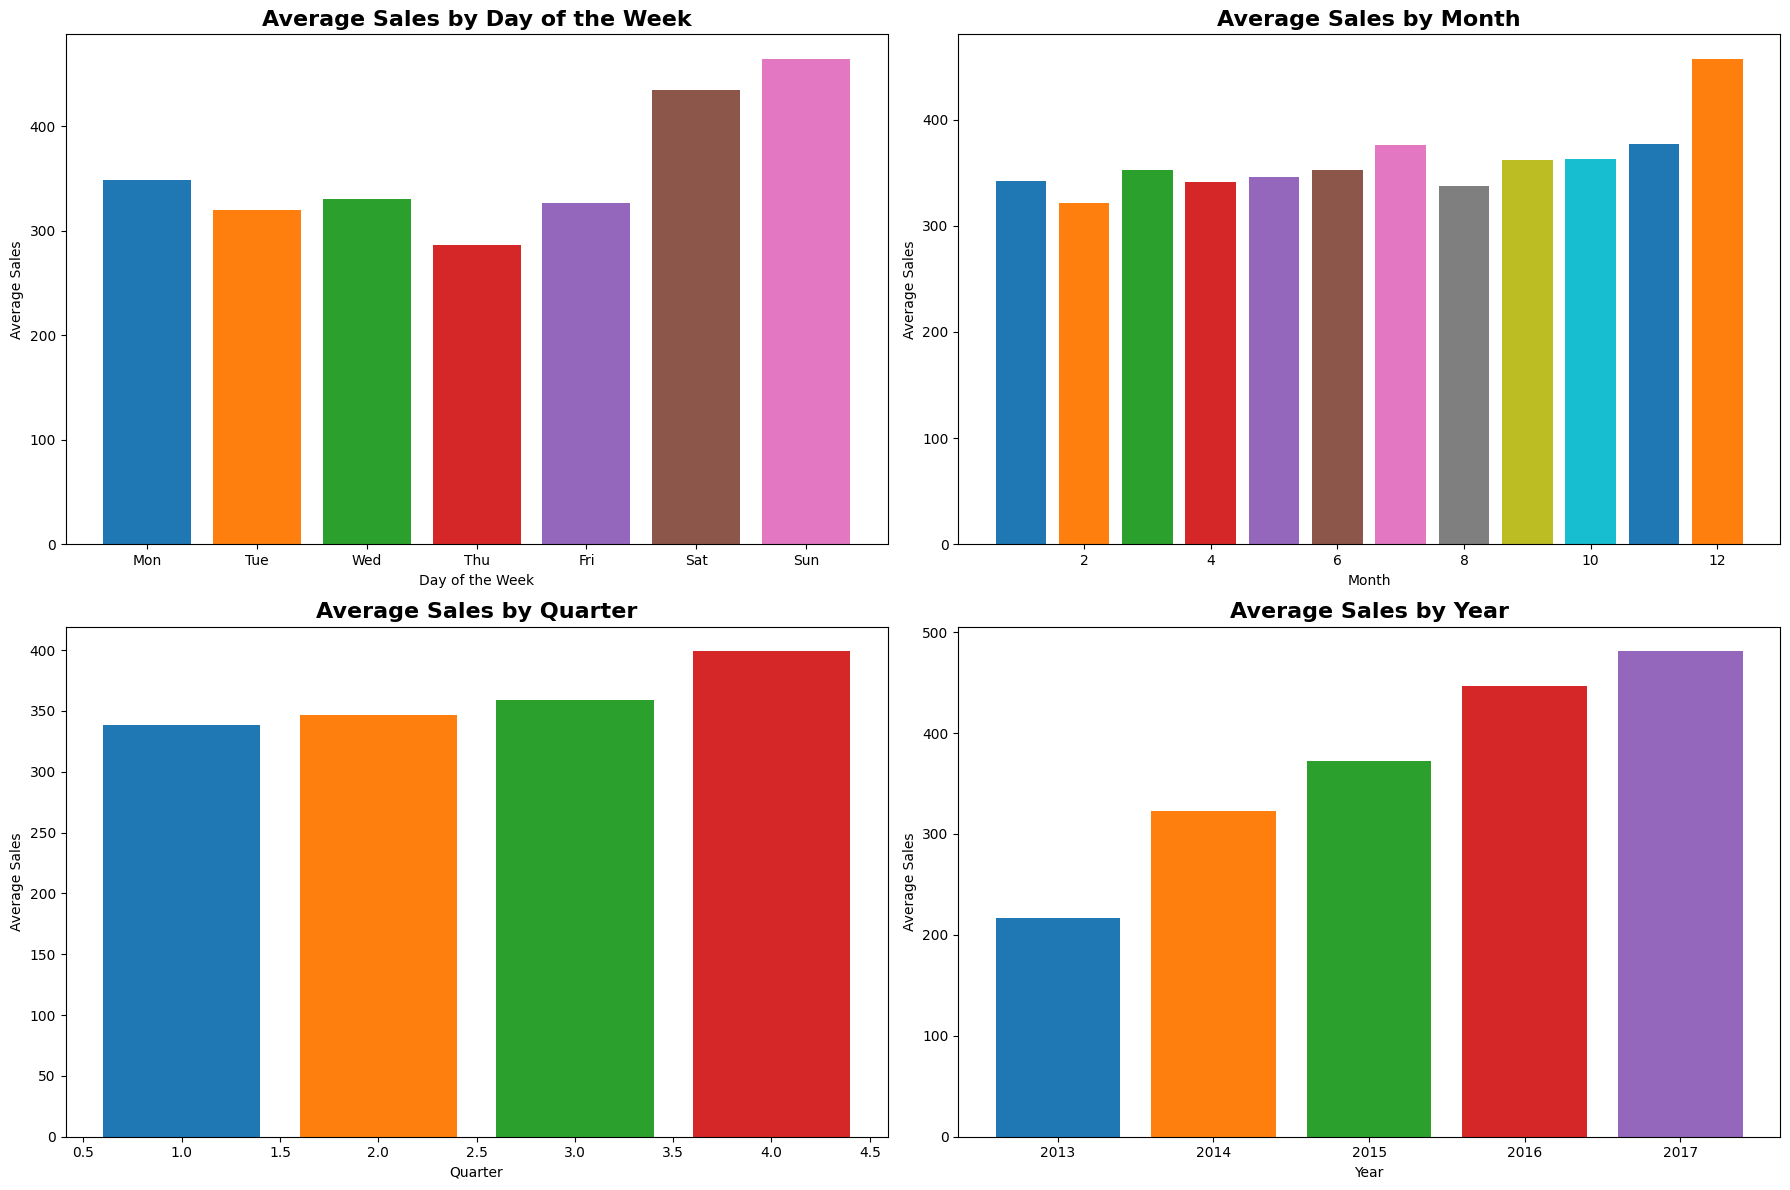

In [51]:
# Extracting date features
train_merged['quarter'] = train_merged['date'].dt.quarter
train_merged['is_weekend'] = train_merged['dayofweek'] >= 5

# Calculating average sales by day of the week
sales_by_day_of_week = train_merged.groupby('dayofweek')['sales'].mean()

# Calculating average sales by month
sales_by_month = train_merged.groupby('month')['sales'].mean()

# Calculating average sales by quarter
sales_by_quarter = train_merged.groupby('quarter')['sales'].mean()

# Calculating average sales by year
sales_by_year = train_merged.groupby('year')['sales'].mean()

# Setting up the figure for subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plotting average sales by day of the week
axs[0, 0].bar(sales_by_day_of_week.index, sales_by_day_of_week, color=palette)
axs[0, 0].set_title('Average Sales by Day of the Week',fontsize=16, weight='bold')
axs[0, 0].set_xlabel('Day of the Week')
axs[0, 0].set_ylabel('Average Sales')
axs[0, 0].set_xticks(range(7))
axs[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plotting average sales by month
axs[0, 1].bar(sales_by_month.index, sales_by_month, color=palette)
axs[0, 1].set_title('Average Sales by Month', fontsize=16, weight='bold')
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_ylabel('Average Sales')

# Plotting average sales by quarter
axs[1, 0].bar(sales_by_quarter.index, sales_by_quarter, color=palette)
axs[1, 0].set_title('Average Sales by Quarter', fontsize=16, weight='bold')
axs[1, 0].set_xlabel('Quarter')
axs[1, 0].set_ylabel('Average Sales')

# Plotting average sales by year
axs[1, 1].bar(sales_by_year.index, sales_by_year, color=palette)
axs[1, 1].set_title('Average Sales by Year', fontsize=16, weight='bold')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Average Sales')


plt.tight_layout()
plt.show()

Average Sales by Day of the Week
- **Saturday and Sunday** have the highest average sales, indicating increased consumer activity during weekends.
- **Thursday** shows the lowest average sales among the days of the week, suggesting a mid-week dip in sales.
- Sales are relatively steady from Monday to Wednesday and pick up significantly on Friday, leading into the weekend.

 Average Sales by Month
- **December** has the highest average sales, likely due to holiday shopping and end-of-year activities.
- **January** and **February** have relatively lower sales, which might be due to post-holiday effects and the start of the new year.
- The middle months show consistent sales with slight variations, indicating steady consumer activity throughout the year.

 Average Sales by Quarter
- **Q4** shows the highest average sales, driven by the holiday season and increased consumer spending in the final months of the year.
- The other quarters (Q1, Q2, Q3) have relatively similar average sales, with no significant fluctuations, indicating stable sales performance across these periods.

 Average Sales by Year
- There is a clear upward trend in average sales from **2013 to 2017**, indicating overall growth in sales performance over these years.
- The most significant increase is observed from **2013 to 2014**, followed by steady growth in subsequent years, suggesting positive business growth and potentially successful marketing or expansion strategies.

#### Key Takeaways
- **Weekend Sales**: The highest sales on weekends highlight the importance of targeting weekend shoppers with promotions and marketing efforts.
- **Seasonal Trends**: December's peak in sales underscores the significance of holiday seasons and the need for strategic planning during this period.
- **Quarterly Analysis**: The strong performance in Q4 suggests focusing on the last quarter for maximizing sales opportunities.
- **Yearly Growth**: The consistent growth year-over-year indicates a positive trajectory, with potential for further expansion and increased sales.

### 8. Which product family and stores did the promotions affect.

In [52]:
# Filtering for promotions in the holidays_events data
promotion_days = holidays_events[holidays_events['type']== 'Event']['date']

# Adding a column in the train data to indicate if a day is a promotion day
train_merged['is_promotion'] = train_merged['date'].isin(promotion_days)

In [53]:
# Calculating sales during promotion and non-promotion periods
sales_during_promotion = train_merged[train_merged['is_promotion']]['sales'].mean()
sales_non_promotion = train_merged[~train_merged['is_promotion']]['sales'].mean()

print(f"Average sales during promotions: {sales_during_promotion}")
print(f"Average sales during non-promotion periods: {sales_non_promotion}")

Average sales during promotions: 419.798198092248
Average sales during non-promotion periods: 356.66346947938143


In [54]:
# Aggregating sales by product family
product_family_sales = pd.DataFrame(train_merged.groupby(['family', 'is_promotion'])['sales'].mean().unstack())
      
# Calculating the difference between promotion and non-promotion periods
product_family_sales['difference'] = product_family_sales[True] - product_family_sales[False]

# Filtering top 5 product families based on sales difference
top_5_product_families = product_family_sales.nlargest(5, 'difference')
top_5_product_families

is_promotion,False,True,difference
family,,,
GROCERY I,3762.408127,4512.943840,750.535713
BEVERAGES,2373.729371,2941.045428,567.316057
PRODUCE,1341.353099,1716.842286,375.489187
DAIRY,707.221077,813.138600,105.917522
HOME CARE,174.330965,253.655382,79.324417


In [55]:
# Aggregate sales by store
store_sales = pd.DataFrame(train_merged.groupby(['store_nbr', 'is_promotion'])['sales'].mean().unstack())

# Calculating the difference between promotion and non-promotion periods
store_sales['difference'] = store_sales[True] - store_sales[False]

# Filtering top 5 product families based on sales difference
top_5_product_families = store_sales.nlargest(5, 'difference')
top_5_product_families

is_promotion,False,True,difference
store_nbr,,,
20,228.666999,440.241021,211.574021
45,977.156804,1175.584304,198.427500
2,382.630921,564.691407,182.060486
44,1113.685523,1285.966149,172.280626
53,198.122162,366.454596,168.332434


### 9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

#### 1. Mean Squared Error (MSE)
- **Definition**: The Mean Squared Error is the average of the squared differences between the predicted and actual values.
- **Properties**: 
  - It penalizes larger errors more than smaller ones due to the squaring of errors.
  - Sensitive to outliers because squaring magnifies large errors.

#### 2. Root Mean Squared Error (RMSE)
- **Definition**: The Root Mean Squared Error is the square root of the Mean Squared Error.
- **Properties**:
  - It has the same units as the target variable.
  - Like MSE, it penalizes larger errors more due to squaring before averaging.

#### 3. Root Mean Squared Logarithmic Error (RMSLE)
- **Definition**: The Root Mean Squared Logarithmic Error measures the ratio between the actual and predicted values by comparing the logarithms of the predicted and actual values.
- **Properties**:
  - Useful when the target variable has exponential growth or when the relative error is more important than the absolute error.
  - Less sensitive to large differences for high target values.

#### 4. Mean Absolute Error (MAE)
- **Definition**: The Mean Absolute Error is the average of the absolute differences between the predicted and actual values.
- **Properties**:
  - It has the same units as the target variable.
  - It treats all errors equally, without squaring them.
  - Less sensitive to outliers compared to MSE and RMSE.

### Why is MAE Often Greater than RMSLE, RMSE, and MSE?

The MAE can be greater than RMSLE, RMSE, and MSE for the following reasons:

1. **Penalization of Errors**:
   - MSE and RMSE penalize larger errors more than smaller ones because of the squaring operation. This can lead to a lower overall average error when large errors are infrequent.
   - RMSLE focuses on the logarithmic difference, which means it is less sensitive to large absolute errors but more sensitive to relative differences, particularly when the true values are small.

2. **Error Aggregation**:
   - MAE aggregates errors linearly. It does not give extra weight to larger errors.
   - In contrast, RMSE and MSE give extra weight to larger errors due to the squaring of the errors, which can reduce the impact of smaller errors on the overall metric.

3. **Error Scale**:
   - RMSLE takes the logarithm of the predicted and actual values, which scales down the impact of larger values. Therefore, the logarithmic transformation tends to reduce the magnitude of the errors before squaring and averaging.

**Conclusion**
- **MAE** is often higher because it considers the absolute error without additional penalization.
- **MSE** and **RMSE** can be lower when large errors are infrequent because they square the errors, reducing the impact of smaller errors.
- **RMSLE** can be much lower if the absolute differences are not large relative to the true values because it works with the logarithmic scale. 

### 10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [56]:
# Removing any rows with missing or infinite sales values
train_merged =train_merged[np.isfinite(train_merged['sales'])]

In [57]:
train_merged['is_15th'] = train_merged['day'] == 15
train_merged['is_last_day'] = train_merged['date'] == (train_merged['date'] + pd.offsets.MonthEnd(0))

# Creating a column to identify if it's either the 15th or the last day
train_merged['is_payday'] = train_merged['is_15th'] | train_merged['is_last_day']

In [58]:
# Calculating average sales
avg_sales_15th = train_merged[train_merged['is_15th']]['sales'].mean()
avg_sales_last_day = train_merged[train_merged['is_last_day']]['sales'].mean()
avg_sales_payday = train_merged[train_merged['is_payday']]['sales'].mean()
avg_sales_other_days = train_merged[~train_merged['is_payday']]['sales'].mean()

print(f"Average sales on 15th: {avg_sales_15th}")
print(f"Average sales on last day of the month: {avg_sales_last_day}")
print(f"Average sales on paydays (15th and last day): {avg_sales_payday}")
print(f"Average sales on other days: {avg_sales_other_days}")

Average sales on 15th: 348.73670744734346
Average sales on last day of the month: 376.50322189431483
Average sales on paydays (15th and last day): 362.49489028142847
Average sales on other days: 358.78033468349633


In [59]:
# Sales on paydays
sales_payday = train_merged[train_merged['is_payday']]['sales']

# Sales on other days
sales_other_days = train_merged[~train_merged['is_payday']]['sales']

# Conducting t-test
t_stat, p_value = ttest_ind(sales_payday, sales_other_days)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("We Reject the null hypothesis: Public sector wage payments on the 15th and the last days of the month influence store sales.")
else:
    print("We Fail to reject the null hypothesis: Public sector wage payments on the 15th and the last days of the month do not influence store sales.")

T-statistic: 1.4428589010704627
P-value: 0.14906032526483284
We Fail to reject the null hypothesis: Public sector wage payments on the 15th and the last days of the month do not influence store sales.


Stationarity Test

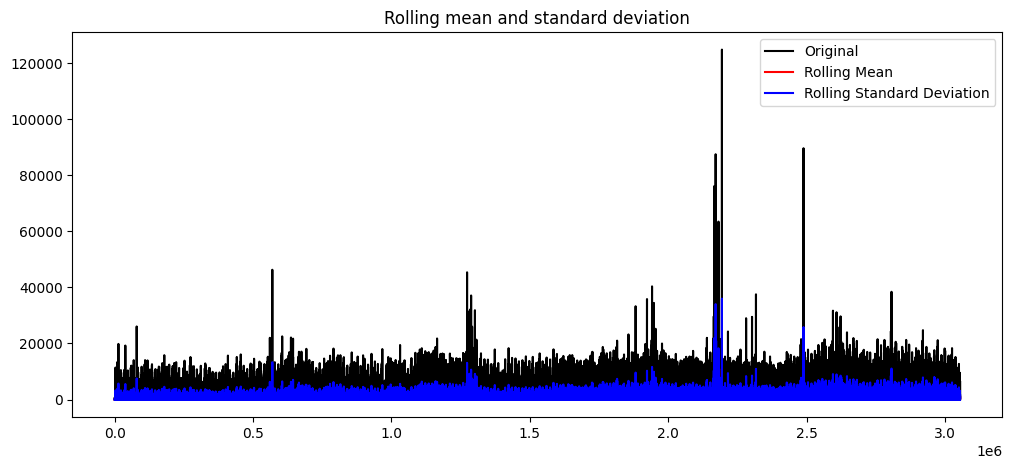

In [60]:
plt.figure(figsize=(12,5))
rmean=train_merged['sales'].rolling(window=12).mean()
rstd=train_merged['sales'].rolling(window=12).std()
# print(rmean,rstd)
orig=plt.plot(train_merged['sales'], color='black',label='Original')
mean= plt.plot(rmean , color='red',label='Rolling Mean')
std=plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show();

### Comment:
From the graph above, the rolling mean and rolling standard deviation is constant, thus the dataset can be said to be stationary

In [61]:
# Save the train dataset as a csv, then carry out feature engineering

train_merged.to_csv('Data/Cleaned_train.csv', index=False)

# Feature Engineering

Feature engineering processes include feature selection, data splitting, feature encoding, feature scaling etc. These processes are required to prepare the dataset for modelling.

### Feature Selection

In [62]:
# Display random sample of 10 rows to see the contents of the columns

train_merged.sample(10, random_state = 42)

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,store_type,...,year,month,day,dayofweek,quarter,is_weekend,is_promotion,is_15th,is_last_day,is_payday
668753,659843.0,2014-01-07,23,DAIRY,471.000,0.0,1135.0,Ambato,Tungurahua,D,...,2014.0,1.0,7.0,1.0,1,False,False,False,False,False
1267004,1250966.0,2014-12-05,1,BEAUTY,1.000,0.0,2028.0,Quito,Pichincha,D,...,2014.0,12.0,5.0,4.0,4,False,False,False,False,False
997442,981404.0,2014-07-06,45,HOME APPLIANCES,0.000,0.0,4626.0,Quito,Pichincha,A,...,2014.0,7.0,6.0,6.0,3,True,False,False,False,False
873596,864686.0,2014-05-02,20,LAWN AND GARDEN,0.000,0.0,0.0,Quito,Pichincha,B,...,2014.0,5.0,2.0,4.0,2,False,False,False,False,False
756145,747235.0,2014-02-25,25,HOME AND KITCHEN II,0.000,0.0,705.0,Salinas,Santa Elena,D,...,2014.0,2.0,25.0,1.0,1,False,False,False,False,False
703557,694647.0,2014-01-26,49,PRODUCE,7866.909,0.0,2744.0,Quito,Pichincha,A,...,2014.0,1.0,26.0,6.0,1,True,False,False,False,False
1247050,1231012.0,2014-11-23,49,GROCERY II,107.000,0.0,3096.0,Quito,Pichincha,A,...,2014.0,11.0,23.0,6.0,4,True,False,False,False,False
426324,419196.0,2013-08-24,20,PRODUCE,0.000,0.0,0.0,Quito,Pichincha,B,...,2013.0,8.0,24.0,5.0,3,True,False,False,False,False
1702905,1677957.0,2015-08-02,4,CELEBRATION,11.000,0.0,1716.0,Quito,Pichincha,D,...,2015.0,8.0,2.0,6.0,3,True,False,False,False,False
313127,311345.0,2013-06-24,44,MAGAZINES,0.000,0.0,3584.0,Quito,Pichincha,A,...,2013.0,6.0,24.0,0.0,2,False,False,False,False,False


In [63]:
# Display all the columns of the dataset

train_merged.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'transactions', 'city', 'state', 'store_type', 'cluster', 'dcoilwtico',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'year', 'month', 'day', 'dayofweek', 'quarter', 'is_weekend',
       'is_promotion', 'is_15th', 'is_last_day', 'is_payday'],
      dtype='object')

In [64]:
# Drop some columns and display the dataset
columns_to_drop = [ 'id', 'transactions', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'dcoilwtico', 'city',
                   'state', 'store_type', 'cluster',  'month', 'is_weekend', 'dayofweek',  'day', 'quarter', 'is_promotion', 'is_15th', 'is_last_day', 'is_payday']
train_merged = train_merged.drop(columns_to_drop, axis=1)

train_merged.head()

,date,store_nbr,family,sales,onpromotion,year
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,2013.0
1,2013-01-01,1,BABY CARE,0.0,0.0,2013.0
2,2013-01-01,1,BEAUTY,0.0,0.0,2013.0
3,2013-01-01,1,BEVERAGES,0.0,0.0,2013.0
4,2013-01-01,1,BOOKS,0.0,0.0,2013.0


In [65]:
# Set 'date' column as index
train_merged.set_index('date', inplace=True)

train_merged.head()

,store_nbr,family,sales,onpromotion,year
date,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0.0,2013.0
2013-01-01,1,BABY CARE,0.0,0.0,2013.0
2013-01-01,1,BEAUTY,0.0,0.0,2013.0
2013-01-01,1,BEVERAGES,0.0,0.0,2013.0
2013-01-01,1,BOOKS,0.0,0.0,2013.0


### Data Splitting

The dataset will be splitted to training and validation sets using the time-based split. This will be done based on the years.

In [66]:
# List the years in the dataset

train_merged['year'].unique()

array([2013., 2014., 2015., 2016., 2017.])

In [67]:
# Establish the years for the training set and validation set
train_years = [2013, 2014, 2015, 2016]
val_year = [2017]

# Obtain the training set and validation set
train_set = train_merged.loc[(train_merged['year'].isin(train_years) & train_merged['year'].isin(train_years))]
val_set = train_merged.loc[(train_merged['year'].isin(val_year) & train_merged['year'].isin(val_year))]

# Print the shape of the training set and validation set
train_set.shape, val_set.shape

((2642706, 5), (411642, 5))

In [68]:
# Check the datatypes of the columns of the training set

train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2642706 entries, 2013-01-01 to 2016-12-31
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  float64
 4   year         float64
dtypes: float64(3), int64(1), object(1)
memory usage: 121.0+ MB


In [69]:
# Extract the original index column for later use
train_index = train_set.index
val_index = val_set.index

# Obtain the categorical columns to encode and numerical columns to scale (I dropped the 'Year' column here)
cat_columns_to_encode = ['family']
num_columns_to_scale = ['store_nbr', 'onpromotion', 'sales']

# Create seperate DataFrames for categorical columns and numerical columns of training set
train_set_cat_df = train_set[cat_columns_to_encode]
train_set_num_df = train_set[num_columns_to_scale]

# Create seperate DataFrames for categorical columns and numerical columns of validation set
val_set_cat_df = val_set[cat_columns_to_encode]
val_set_num_df = val_set[num_columns_to_scale]

### Feature Encoding

In [70]:
# Create an encoder object using OneHotEncoder.
# Set sparse=False for dense output and drop='first' to avoid multicollinearity

encoder = OneHotEncoder(sparse_output=False, drop='first')

In [71]:
# Use OneHotEncoder to encode the categorical columns of the training set
encoder.fit(train_set_cat_df)
train_set_cat_encoded = encoder.transform(train_set_cat_df).tolist()
train_set_cat_encoded_df = pd.DataFrame(train_set_cat_encoded, columns=encoder.get_feature_names_out(), index=train_index)

# View the encoded columns of the training set
train_set_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# Use OneHotEncoder to encode the categorical columns of the validation set
encoder.fit(val_set_cat_df)
val_set_cat_encoded = encoder.transform(val_set_cat_df).tolist()
val_set_cat_encoded_df = pd.DataFrame(val_set_cat_encoded, columns=encoder.get_feature_names_out(), index=val_index)

# View the encoded columns of the validation set
val_set_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Scaling

MinMaxScaler will be used for feature scaling as it is suitable for time series data because it preserves the relative differences between data points and maintains the temporal information.

In [73]:
# Create a scaler object using MinMaxScaler

scaler = MinMaxScaler()

In [74]:
# Use MinMaxScaler to scale the numerical columns of the training set
scaler.fit(train_set_num_df)
train_set_num_scaled = scaler.transform(train_set_num_df).tolist()
train_set_num_scaled_df = pd.DataFrame(train_set_num_scaled, columns=scaler.get_feature_names_out(), index=train_index)

# View the scaled columns of the training set
train_set_num_scaled_df.head()

,store_nbr,onpromotion,sales
date,,,
2013-01-01,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0


In [75]:
# Use MinMaxScaler to scale the numerical columns of the validation set
scaler.fit(val_set_num_df)
val_set_num_scaled = scaler.transform(val_set_num_df).tolist()
val_set_num_scaled_df = pd.DataFrame(val_set_num_scaled, columns=scaler.get_feature_names_out(), index=val_index)

# View the scaled columns of the validation set
val_set_num_scaled_df.head()

,store_nbr,onpromotion,sales
date,,,
2017-01-01,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0


In [76]:
# Combine the encoded and scaled DataFrames to get the final training and validation sets
train_final = pd.concat([train_set_cat_encoded_df, train_set_num_scaled_df], axis=1)
val_final = pd.concat([val_set_cat_encoded_df, val_set_num_scaled_df], axis=1)

# Print the shape of the final training and validation sets
train_final.shape, val_final.shape

((2642706, 35), (411642, 35))

In [77]:
# Display the first five rows of the final training set

train_final.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_nbr,onpromotion,sales
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# Display the first five rows of the final validation set

val_final.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_nbr,onpromotion,sales
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# Separate the features (X) and the target variable (y) for training and validation sets
X_train = train_final.drop('sales', axis=1)
y_train = train_final['sales']
X_val = val_final.drop('sales', axis=1)
y_val = val_final['sales']

# Replace the elements of y_val with their absolute value in order to eliminate the presence of negative values in the y_val array
y_val = np.abs(y_val)
y_val = y_val.reset_index(drop=True)
y_val = y_val[y_val >= 0]

# Verify the lengths of the features(X) and the target variable (y) of the final training and validation sets
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_test:", len(X_val))
print("Length of y_test:", len(y_val))

Length of X_train: 2642706
Length of y_train: 2642706
Length of X_test: 411642
Length of y_test: 411642


# Modelling

The following models will be trained and evaluated:
1. Linear Regression

2. XGBoost

3. CatBoost

4. AutoRegressive (AutoReg)

5. AutoRegressive Integrated Moving Average (ARIMA)

6. Seasonal AutoRegressive Integrated Moving Average (SARIMA)

The following evaluation metrics will be used to evaluate the performance of the models.

- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Squared Logarithmic Error (MSLE)
- Root Mean Squared Logarithmic Error (RMSLE)

The primary evaluation metric for selecting the best performing model is the Root Mean Squared Logarithmic Error (RMSLE).

In [80]:
# Create an empty DataFrame to store the results of the evaluation metrics of each model

results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MSLE', 'RMSLE'])
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE


### Model 1: Linear Regression

In [81]:
# Initialize the model
linear_regression_model = LinearRegression()

# Fit the model
linear_regression_model.fit(X_train, y_train)

# Make predictions on the final validation set
linear_regression_pred = linear_regression_model.predict(X_val)

# Calculate the evaluation metrics
linear_regression_mae = mean_absolute_error(y_val, linear_regression_pred)
linear_regression_mse = mean_squared_error(y_val, linear_regression_pred)
linear_regression_rmse = np.sqrt(linear_regression_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def linear_regression_msle_with_non_negative_targets(y_val, linear_regression_pred):
    # Add a constant value to all target values to ensure they are non-negative
    y_val_non_negative = y_val + np.abs(np.min(y_val)) + 1
    
    # Add the same constant value to the predicted values
    linear_regression_pred_non_negative = linear_regression_pred + np.abs(np.min(y_val)) + 1
    
    # Calculate the MSLE using the transformed targets
    linear_regression_msle = mean_squared_log_error(y_val_non_negative, linear_regression_pred_non_negative)
    return linear_regression_msle

# Calculate msle using the custom function, then calculate rmsle
linear_regression_msle = linear_regression_msle_with_non_negative_targets(y_val, linear_regression_pred)
linear_regression_rmsle = np.sqrt(linear_regression_msle)

# Create a dictionary for the evaluation metrics of Linear Regression model
linear_regression_evaluation_metrics = pd.DataFrame({'Model': ['Linear Regression'], 'MAE': [linear_regression_mae],
                                                     'MSE': [linear_regression_mse], 'RMSE': [linear_regression_rmse],
                                                     'MSLE': [linear_regression_msle], 'RMSLE': [linear_regression_rmsle]})

# Add the linear regression evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, linear_regression_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727


### Model 2: XGBoost

In [82]:
# Initialize the model
xgboost_model = XGBRegressor()

# Fit the model
xgboost_model.fit(X_train, y_train)

# Make predictions on the final validation set
xgboost_pred = xgboost_model.predict(X_val)

# Calculate the evaluation metrics
xgboost_mae = mean_absolute_error(y_val, xgboost_pred)
xgboost_mse = mean_squared_error(y_val, xgboost_pred)
xgboost_rmse = np.sqrt(xgboost_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def xgboost_msle_with_non_negative_targets(y_val, xgboost_pred):
    # Add a constant value to all target values to ensure they are non-negative
    y_val_non_negative = y_val + np.abs(np.min(y_val)) + 1
    
    # Add the same constant value to the predicted values
    xgboost_pred_non_negative = xgboost_pred + np.abs(np.min(y_val)) + 1
    
    # Calculate the MSLE using the transformed targets
    xgboost_msle = mean_squared_log_error(y_val_non_negative, xgboost_pred_non_negative)
    return xgboost_msle

# Calculate msle using the custom function, then calculate rmsle
xgboost_msle = xgboost_msle_with_non_negative_targets(y_val, xgboost_pred)
xgboost_rmsle = np.sqrt(xgboost_msle)

# Create a dictionary for the evaluation metrics of xgboost model
xgboost_evaluation_metrics = pd.DataFrame({'Model': ['XGBoost'], 'MAE': [xgboost_mae], 'MSE': [xgboost_mse], 'RMSE': [xgboost_rmse],
                                           'MSLE': [xgboost_msle], 'RMSLE': [xgboost_rmsle]})

# Add the xgboost evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, xgboost_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141


### Model 3: CatBoost

In [83]:
# Initialize the model
catboost_model = CatBoostRegressor(verbose=False)

# Fit the model
catboost_model.fit(X_train, y_train)

# Make predictions on the final validation set
catboost_pred = catboost_model.predict(X_val)

# Calculate the evaluation metrics
catboost_mae = mean_absolute_error(y_val, catboost_pred)
catboost_mse = mean_squared_error(y_val, catboost_pred)
catboost_rmse = np.sqrt(catboost_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def catboost_msle_with_non_negative_targets(y_val, catboost_pred):
    # Add a constant value to all target values to ensure they are non-negative
    y_val_non_negative = y_val + np.abs(np.min(y_val)) + 1
    
    # Add the same constant value to the predicted values
    catboost_pred_non_negative = catboost_pred + np.abs(np.min(y_val)) + 1
    
    # Calculate the MSLE using the transformed targets
    catboost_msle = mean_squared_log_error(y_val_non_negative, catboost_pred_non_negative)
    return catboost_msle

# Calculate msle using the custom function, then calculate rmsle
catboost_msle = catboost_msle_with_non_negative_targets(y_val, catboost_pred)
catboost_rmsle = np.sqrt(catboost_msle)

# Create a dictionary for the evaluation metrics of catboost model
catboost_evaluation_metrics = pd.DataFrame({'Model': ['CatBoost'], 'MAE': [catboost_mae], 'MSE': [catboost_mse], 'RMSE': [catboost_rmse],
                                           'MSLE': [catboost_msle], 'RMSLE': [catboost_rmsle]})

# Add the catboost evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, catboost_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141
2,CatBoost,0.008959,0.000784,0.027996,0.000173,0.013134


### Model 4: AutoRegressive (AutoReg)

In [84]:
# Determine the best lag using Akaike Information Criterion (AIC)
max_lag = 10  # Define the maximum lag order to consider
best_aic = float('inf')  # Initialize best_aic to positive infinity
best_lag = 0  # Initialize best_lag to zero

for lag in range(1, max_lag + 1):
    aic_AR_model = AutoReg(y_train, lags=lag)
    aic_AR_model_fit = aic_AR_model.fit()
    aic = -2 * aic_AR_model_fit.llf + 2 * (lag + 1)  # Calculate AIC manually
    if aic < best_aic:
        best_aic = aic
        best_lag = lag

# Print the best lag
print(f'The best lag is: {best_lag}')

The best lag is: 10


In [85]:
# Initialize the model
AR_model = AutoReg(y_train, lags=best_lag)

# Fit the model
AR_model_fit = AR_model.fit()

# Make predictions
AR_start = len(y_train)
AR_end = len(y_train) + len(y_val) - 1
AR_pred = AR_model_fit.predict(start=AR_start, end=AR_end)

# Calculate evaluation metrics
AR_mae = mean_absolute_error(y_val, AR_pred)
AR_mse = mean_squared_error(y_val, AR_pred)
AR_rmse = np.sqrt(AR_mse)
AR_msle = mean_squared_log_error(y_val, AR_pred)
AR_rmsle = np.sqrt(AR_msle)

# Create a dictionary for the evaluation metrics of the AR model
AR_evaluation_metrics = pd.DataFrame({'Model': ['AutoReg'], 'MAE': [AR_mae], 'MSE': [AR_mse], 'RMSE': [AR_rmse], 'MSLE': [AR_msle], 'RMSLE': [AR_rmsle]})

# Add the AR evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, AR_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141
2,CatBoost,0.008959,0.000784,0.027996,0.000173,0.013134
3,AutoReg,0.012682,0.001346,0.036686,0.001113,0.033358


### Model 5: AutoRegressive Integrated Moving Average (ARIMA)

In [86]:
# Define the (p, d, q) parameters for ARIMA
ARIMA_order = (2, 1, 1)

# Initialize the model
ARIMA_model = ARIMA(y_train, order=ARIMA_order)

# Fit the model
ARIMA_model_fit = ARIMA_model.fit()

# Make predictions
ARIMA_start = len(y_train)
ARIMA_end = len(y_train) + len(y_val) - 1
ARIMA_pred = ARIMA_model_fit.predict(start=ARIMA_start, end=ARIMA_end)

# Calculate evaluation metrics
ARIMA_mae = mean_absolute_error(y_val, ARIMA_pred)
ARIMA_mse = mean_squared_error(y_val, ARIMA_pred)
ARIMA_rmse = np.sqrt(ARIMA_mse)
ARIMA_msle = mean_squared_log_error(y_val, ARIMA_pred)
ARIMA_rmsle = np.sqrt(ARIMA_msle)

# Create a dictionary for the evaluation metrics of ARIMA model
ARIMA_evaluation_metrics = pd.DataFrame({'Model': ['ARIMA'], 'MAE': [ARIMA_mae], 'MSE': [ARIMA_mse], 'RMSE': [ARIMA_rmse], 'MSLE': [ARIMA_msle],
                                      'RMSLE': [ARIMA_rmsle]})

# Add the ARIMA evaluation metrics to the results DataFrame, then print the results DataFrame
results = pd.concat([results, ARIMA_evaluation_metrics], ignore_index=True)
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141
2,CatBoost,0.008959,0.000784,0.027996,0.000173,0.013134
3,AutoReg,0.012682,0.001346,0.036686,0.001113,0.033358
4,ARIMA,0.013223,0.001315,0.036265,0.001084,0.032928


### Model 6: Seasonal AutoRegressive Integrated Moving Average (SARIMA)

##### The codes were not run due to lack of memory

In [87]:
results

,Model,MAE,MSE,RMSE,MSLE,RMSLE
0,Linear Regression,0.009328,0.000979,0.031287,0.000217,0.014727
1,XGBoost,0.008944,0.000784,0.028009,0.000173,0.013141
2,CatBoost,0.008959,0.000784,0.027996,0.000173,0.013134
3,AutoReg,0.012682,0.001346,0.036686,0.001113,0.033358
4,ARIMA,0.013223,0.001315,0.036265,0.001084,0.032928


From the result table above showing the evaluation metrics of all the models after training and validation, it is observed that CatBoost model has the lowest score (or joint lowest score) for all the evaluation metrics except the MAE where XGBoost has the lowest score. The evaluation metrics of Catboost model is as shown below:

- Mean Absolute Error (MAE): 0.008959
- Mean Squared Error (MSE): 0.000784
- Root Mean Squared Error (RMSE): 0.027996
- Mean Squared Logarithmic Error (MSLE): 0.000173
- Root Mean Squared Logarithmic Error (RMSLE): 0.013134

Since the primary evaluation metric for selecting the best performing model is the Root Mean Squared Logarithmic Error (RMSLE), the best performing model being the one that has the lowest score for this metric (and the score being less than 0.02), the best performing model is CatBoost model.

## Hyperparameter tuning on the best model

In [96]:
from sklearn.metrics import make_scorer, mean_squared_log_error
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Define the hyperparameter search space
param_distributions = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 7],
    'n_estimators': [500, 1000]
}

# Define the scoring metric as negative RMSLE (to minimize it)
rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

# Initialize the model
catboost_model = CatBoostRegressor(verbose=100, early_stopping_rounds=50)

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_distributions,
    n_iter=3,
    scoring=rmsle_scorer,
    random_state=42,
    cv=3
)

# Fit the randomized search on a subset of the training dataset
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)
random_search.fit(X_train_sub, y_train_sub)

# Get the best model from the randomized search
best_model = random_search.best_estimator_

# Train the best model on the entire training dataset
best_model.fit(X_train, y_train)


0:	learn: 0.0082379	total: 18.3ms	remaining: 18.3s
100:	learn: 0.0043532	total: 1.81s	remaining: 16.1s
200:	learn: 0.0041087	total: 4s	remaining: 15.9s
300:	learn: 0.0039673	total: 5.66s	remaining: 13.2s
400:	learn: 0.0038743	total: 7.41s	remaining: 11.1s
500:	learn: 0.0038069	total: 9.24s	remaining: 9.2s
600:	learn: 0.0037480	total: 10.9s	remaining: 7.26s
700:	learn: 0.0037042	total: 12.7s	remaining: 5.41s
800:	learn: 0.0036730	total: 14.4s	remaining: 3.57s
900:	learn: 0.0036397	total: 16s	remaining: 1.76s
999:	learn: 0.0036143	total: 17.5s	remaining: 0us
0:	learn: 0.0082793	total: 17.5ms	remaining: 17.5s
100:	learn: 0.0043398	total: 1.55s	remaining: 13.8s
200:	learn: 0.0040931	total: 3s	remaining: 11.9s
300:	learn: 0.0039524	total: 4.49s	remaining: 10.4s
400:	learn: 0.0038544	total: 6.01s	remaining: 8.97s
500:	learn: 0.0037835	total: 7.42s	remaining: 7.39s
600:	learn: 0.0037281	total: 8.91s	remaining: 5.91s
700:	learn: 0.0036893	total: 10.3s	remaining: 4.4s
800:	learn: 0.0036589	tota

# Prediction on validation set

In [97]:

# Make predictions on the final validation set
best_model_pred = best_model.predict(X_val)

# Calculate the evaluation metrics of the best model
best_model_mae = mean_absolute_error(y_val, best_model_pred)
best_model_mse = mean_squared_error(y_val, best_model_pred)
best_model_rmse = np.sqrt(best_model_mse)

# Define custom function to handle the negative predictions in order to calculate msle
def best_model_msle_with_non_negative_targets(y_val, best_model_pred):
    # Add a constant value to all target values to ensure they are non-negative
    offset = np.abs(np.min(y_val)) + 1
    y_val_non_negative = y_val + offset
    best_model_pred_non_negative = best_model_pred + offset
    
    # Calculate the MSLE using the transformed targets
    best_model_msle = mean_squared_log_error(y_val_non_negative, best_model_pred_non_negative)
    return best_model_msle

# Calculate msle using the custom function, then calculate rmsle
best_model_msle = best_model_msle_with_non_negative_targets(y_val, best_model_pred)
best_model_rmsle = np.sqrt(best_model_msle)

# Print the evaluation metrics of the best model
print('Best Model: CatBoost')
print('MAE: ', best_model_mae)
print('MSE: ', best_model_mse)
print('RMSE: ', best_model_rmse)
print('MSLE: ', best_model_msle)
print('RMSLE: ', best_model_rmsle)


Best Model: CatBoost
MAE:  0.008968261054153343
MSE:  0.0007930487521359654
RMSE:  0.028161121286908397
MSLE:  0.00017459544697774024
RMSLE:  0.013213457041128194


In [98]:

# Create a dictionary for the evaluation metrics of the best model (tuned catboost)
best_model_evaluation_metrics = pd.DataFrame({
    'Model': ['Best Model (Tuned CatBoost)'],
    'MAE': [best_model_mae],
    'MSE': [best_model_mse],
    'RMSE': [best_model_rmse],
    'MSLE': [best_model_msle],
    'RMSLE': [best_model_rmsle]
})

# Add the evaluation metrics of the best model to the results DataFrame
results = pd.concat([results, best_model_evaluation_metrics], ignore_index=True)

# Print the results DataFrame to compare the scores
print(results)


                         Model       MAE       MSE      RMSE      MSLE  \
0            Linear Regression  0.009328  0.000979  0.031287  0.000217   
1                      XGBoost  0.008944  0.000784  0.028009  0.000173   
2                     CatBoost  0.008959  0.000784  0.027996  0.000173   
3                      AutoReg  0.012682  0.001346  0.036686  0.001113   
4                        ARIMA  0.013223  0.001315  0.036265  0.001084   
5  Best Model (Tuned CatBoost)  0.008968  0.000793  0.028161  0.000175   

      RMSLE  
0  0.014727  
1  0.013141  
2  0.013134  
3  0.033358  
4  0.032928  
5  0.013213  


# Prediction on test dataset

In [99]:
# View test dataset

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [100]:
# Rename test to test_df to preserve the originality of test for later use
test_df = test

# Set the 'date' column of test_df as index
test_df = test_df.set_index('date')

# Extract the index column  of test_df for later use
test_index = test_df.index

# View the resulting test dataset
test_df.head()

,id,store_nbr,family,onpromotion
date,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0
2017-08-16,3000889,1,BABY CARE,0
2017-08-16,3000890,1,BEAUTY,2
2017-08-16,3000891,1,BEVERAGES,20
2017-08-16,3000892,1,BOOKS,0


In [101]:
# Specify new numerical columns to scale as 'sales' column is absent in test dataset
test_num_columns_to_scale = ['store_nbr', 'onpromotion']

# Create seperate DataFrames for categorical columns and numerical columns of test_df
test_cat_df = test_df[cat_columns_to_encode]
test_num_df = test_df[test_num_columns_to_scale]

In [102]:
# Use OneHotEncoder to encode the categorical columns of test dataset
encoder.fit(test_cat_df)
test_cat_encoded = encoder.transform(test_cat_df).tolist()
test_cat_encoded_df = pd.DataFrame(test_cat_encoded, columns=encoder.get_feature_names_out(), index=test_index)

# View the encoded columns of test dataset
test_cat_encoded_df.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Use MinMaxScaler to scale the numerical columns of test dataset
scaler.fit(test_num_df)
test_num_scaled = scaler.transform(test_num_df).tolist()
test_num_scaled_df = pd.DataFrame(test_num_scaled, columns=scaler.get_feature_names_out(), index=test_index)

# View the scaled columns of test dataset
test_num_scaled_df.head()

,store_nbr,onpromotion
date,,
2017-08-16,0.0,0.000000
2017-08-16,0.0,0.000000
2017-08-16,0.0,0.003096
2017-08-16,0.0,0.030960
2017-08-16,0.0,0.000000


In [104]:
# Combine the encoded and scaled DataFrames to get the final test dataset
test_final = pd.concat([test_cat_encoded_df, test_num_scaled_df], axis=1)

# Print the shape of the final test dataset
test_final.shape

(28512, 34)

In [105]:
# Display the first five rows of the final test dataset

test_final.head()

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,store_nbr,onpromotion
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-08-16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2017-08-16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003096
2017-08-16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030960
2017-08-16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [106]:
# Make predictions on the final test dataset using the best model
test_pred = best_model.predict(test_final)

# Print the test predictions
print('Predictions:')
test_pred

Predictions:


array([-0.00021229, -0.00025406, -0.00097123, ...,  0.01031811,
        0.00206542,  0.00034489])

In [107]:
# Save the absolute values of sales predictions into test dataset as 'sales' column values
test['sales'] = np.abs(test_pred)

# Print the updated test dataset with absolute predictions
test

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0.000212
1,3000889,2017-08-16,1,BABY CARE,0,0.000254
2,3000890,2017-08-16,1,BEAUTY,2,0.000971
3,3000891,2017-08-16,1,BEVERAGES,20,0.020073
4,3000892,2017-08-16,1,BOOKS,0,0.000260
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,0.004036
28508,3029396,2017-08-31,9,PREPARED FOODS,0,0.000756
28509,3029397,2017-08-31,9,PRODUCE,1,0.010318
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,0.002065


In [108]:
# View sample submission dataset

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [109]:
# Create submission dataset
submission = test[['id', 'sales']]

# Display the first five rows of submission dataset
submission.head()

,id,sales
0,3000888,0.000212
1,3000889,0.000254
2,3000890,0.000971
3,3000891,0.020073
4,3000892,0.000260


In [110]:
# Save submission dataset as csv

submission.to_csv('Data/Submission.csv', index=False)

# Exportation

The key Machine Learning objects such as the best model, encoder, and scaler will be exported. 

In [111]:

# Create a dictionary to store all the Machine Learning components
model_components = {
    'model': best_model,
    'encoder': encoder,
    'scaler': scaler
}

# Create an export folder named 'export'
os.makedirs('export', exist_ok=True)

# Create a path to the export folder
destination = os.path.join('.', 'export')

# Save the components to a file using pickle
with open(os.path.join(destination, 'ml_components.pkl'), 'wb') as f:
    pickle.dump(model_components, f)

# Save the best model (tuned CatBoost model) using CatBoost's built-in method for serialization
best_model.save_model(os.path.join(destination, 'catboost_model.cbm'))

# Create requirements.txt file in export folder to describe the virtual environment used for the Machine Learning processes
!pip freeze > export/requirements.txt

# Create a ZIP archive of the export folder
with zipfile.ZipFile('export.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk('export'):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), 'export'))

print("All components have been successfully saved and archived.")


All components have been successfully saved and archived.


## CONCLUSION

---

In this time series forecasting project, we aimed to predict sales for Corporation Favorita, a retail store in Ecuador, using historical sales data. The objective was to build an effective predictive model that could provide accurate sales forecasts, aiding the company in making informed decisions and optimizing operations.

### Project Overview:

1. **Data Preparation and Analysis**:
   - Extensive data preparation and feature engineering were carried out to enhance the dataset.
   - Six different models were trained, and their evaluation metrics were compared.

2. **Model Selection**:
   - The CatBoost model emerged as the top performer, with the lowest scores in all evaluation metrics except MAE.
   - Our primary evaluation metric, Root Mean Squared Logarithmic Error (RMSLE), was lowest for the CatBoost model at 0.013134, making it the best performing model.

3. **Hyperparameter Tuning**:
   - Cross-validation was used to tune the hyperparameters of the CatBoost model.
   - Optimal hyperparameters were selected to prevent overfitting and achieve the best predictive performance.

4. **Model Saving and Export**:
   - The best model and related components were saved and exported for app deployment.
   - CatBoost's `save_model` method was used to ensure proper serialization and handling of model persistence. This ensures the model is saved and loaded correctly with all its settings, including hyperparameters, feature names, and other necessary information.

### Key Takeaways:

1. **Sales Trends**:
   - An upward trend in sales was observed over the years, with zero sales on the first day of each year.
   - Transactions and sales peak at the end of each year.

2. **Impact of External Events**:
   - The earthquake in Ecuador on April 16, 2016, impacted sales, causing a significant increase.

3. **Store Performance**:
   - Sales varied by store clusters, cities, states, and store types.
   - Promotions, oil prices, and holidays significantly affected sales.
     - Promotions led to increased sales.
     - Higher oil prices generally decreased sales volume.
     - Holidays resulted in higher sales.

4. **Day-of-Week Analysis**:
   - Sales were higher on weekends, with the highest sales on Sundays, followed by Saturdays.
   - Thursdays recorded the lowest sales.

5. **Yearly Sales**:
   - The year 2016 recorded the highest sales, largely due to the post-earthquake sales surge.
   - The lowest sales were recorded in 2013.

This project highlights the comprehensive process of developing a time series forecasting solution for Corporation Favorita, from data preparation to model selection, training, and deployment. Implementing these strategies and techniques enables accurate sales forecasts, helping the retail company optimize operations and make data-driven decisions for growth and success.

---